### Playground Numerical Series

In [1]:
# import json
# def retrieveJSONTasks(filename, features=False):
#     """
#     For JSON of the form:
#         {"name": str,
#          "type": {"input" : bool|int|list-of-bool|list-of-int,
#                   "output": bool|int|list-of-bool|list-of-int},
#          "examples": [{"i": data, "o": data}]}
#     """
#     with open(filename, "r") as f:
#         loaded = json.load(f)
#     TP = {
#         "bool": "bool",
#         "int": "int",
#         "list-of-bool": "list-of-bool",
#         "list-of-int": "list-of-int",
#     }
#     return [(
#         item["name"],
#         TP[item["type"]["input"]], TP[item["type"]["output"]],
#         [(ex["i"], ex["o"]) for ex in item["examples"]],
#     ) for item in loaded]

In [2]:
# path = "tree-of-thought-llm/src/tot/data/numbers/list_tasks.json"
# tasks = retrieveJSONTasks(path)

In [3]:
'''
6-10: Append index k 
17-22:  bool-identify-geq-k with k=0 --> Kaum machbar mit 3 examples

'''

'\n6-10: Append index k \n17-22:  bool-identify-geq-k with k=0 --> Kaum machbar mit 3 examples\n\n'

In [4]:
# for i, t in enumerate(tasks):
#     print(i, t[0])

In [5]:
# print("Examples:")
# idx = 24
# border = 13
# for i, ex in enumerate(tasks[idx][3]):
#     if i < border:
#         print(ex[0], "->", ex[1])
#     if i == border:
#         print("\n\nWhat are the outputs for the following test cases?")     
#     if i >= border:
#         print(ex[0], "->") 

In [6]:
# print("Solutions:")
# for i, ex in enumerate(tasks[idx][3]):  
#     if i >= border:
#         print(ex[0], "->", ex[1]) 

In [7]:
# def transform_list(input_list):
#     transformed_list = []

#     for value in input_list:
#         if value == 0:
#             transformed_list.append(1)
#         elif value == 1:
#             transformed_list.append(2)
#         elif value == 2:
#             transformed_list.append(0)
#         else:
#             transformed_list.append(value)

#     return transformed_list

# # Test cases
# test_cases = [
#     [2, 2, 2, 1],
#     [1, 1, 2, 1, 2, 2, 2],
#     [1, 0, 0, 2, 0, 1],
#     [],
#     [],
#     [1, 0, 1, 1],
#     [0, 0, 0, 2, 2],
#     [1, 0, 1, 1, 1],
#     [0],
#     [1, 2, 2, 1],
#     [1, 2, 1],
#     [0, 0],
#     [1, 1, 0, 0],
# ]

# for test_case in test_cases:
#     result = transform_list(test_case)
#     print(result)


### Imports & GPU Selection

In [37]:
import numpy as np
from IPython.display import clear_output
import sys
import json
import re
import matplotlib.pyplot as plt
import datetime
import time
from copy import deepcopy
from credentials import *
import shutil
import itertools
import pandas as pd
import ast
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] =  '0,3'

import torch
print(torch.cuda.is_available())

import tiktoken
from datasets import load_dataset, Dataset
from transformers.pipelines.pt_utils import KeyDataset
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline, logging
from langchain.llms import HuggingFacePipeline
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate 
from auto_gptq import exllama_set_max_input_length, AutoGPTQForCausalLM, BaseQuantizeConfig
import openai
import argparse


True


In [38]:

# should be here bc. otherwise GPU device selection is not working
#from utils import *
from tot.methods.arc_utils import *
from tot.models import gpt_usage

In [39]:
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HF_TOKEN
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HF_TOKEN
os.environ['OPENAI_API_KEY'] = OPENAI_KEY
openai.api_key = os.getenv("OPENAI_API_KEY")

### correct where string in string check was buggy

In [11]:
# path = "/work/jbriem/repos/master_thesis/Testing_none_official_result/arc_1D/gpt-4-1106-preview_naive_cot_2024-02-08_09-42-53/tasks"
# for filename in os.listdir(path):
#     if "json" in filename:
#         task_data = json.load(open(os.path.join(path, filename), "r"))
#         if task_data["result"]["success"] == 0:
#             solution = task_data["result"]["solution"]
#             prompt_log = task_data["steps"][0]["prompt_log"]

#             # Replace single letters with quotes around them
#             pattern = re.compile(r'(?<![\'"])([a-zA-Z\.])(?![\'"])')
#             solution_grid = pattern.sub(r"'\1'", solution)  

#             try:
#                 solution_grid = ast.literal_eval(solution_grid)
#                 solution_grid = np.array(solution_grid)
#             except:
#                 error = "Array found in string but error while converting string to array: " + str(grid)
#                 print(error)
#             if solution_grid.shape[0] == 1:
#                 solution = str(solution)[1:-1] #  remove second brackets for 1D ARC tasks
#             is_success = re.sub(r'\s+', ' ', solution).strip() in re.sub(r'\s+', ' ', prompt_log).strip()
#             if is_success:
#                 print(filename)


### Get Costs

In [12]:
# path = "/work/jbriem/repos/master_thesis/results/baseline_cot/"
# cost_data = pd.DataFrame()
# for task in ["arc", "arc_1D", "arc_h_v"]:
#     df = pd.read_csv(f"{path}{task}/summary.csv")
#     df_filtered_1 = df[["model", "usage_total_completion_tokens", "usage_total_prompt_tokens", "usage_total_cost"]][df['model'].str.contains('gpt-3', case=False)]#.groupby("model").sum()
#     df_filtered_2 = df[["model", "usage_total_completion_tokens", "usage_total_prompt_tokens", "usage_total_cost"]][df['model'].str.contains('gpt-4', case=False)]#.groupby("model").sum()
#     concat = pd.concat([df_filtered_1.groupby("model").sum(), df_filtered_2.groupby("model").sum()])
#     concat["task"] = task
#     cost_data = pd.concat([cost_data, concat])
# cost_data = cost_data.reset_index()
# cost_data.to_excel(path+"cost_summary.xlsx", index=False)
# cost_data

### Save solved tasks

In [13]:
# # Source directories
# training_dir = "../ARC/ARC/data/training"
# evaluation_dir = "../ARC/ARC/data/evaluation"
# # Target directory
# target_dir = "ARC_datasets/ARC_solved_tasks"
# copy_solved_tasks("results/", training_dir, evaluation_dir, target_dir)


### Create arc subset similar as in the paper


In [14]:
# # get IDs of 50 ARC tasks to be tested # TODO: original ARC???
# repo = '/work/jbriem/repos/master_thesis/'
# data = pd.read_csv(repo+'ARC_datasets/1D-ARC/LLM4ARC/output-logs/direct-grid/ARC-subset/direct_grid_few_shot_number_3.5.csv')
# tasks = list(data["Task_ID"])
# tasks_jsons, tasks_names, subdirecotries = load_arc_tasks(repo+'ARC_datasets/ARC', dataset="arc")
# os.makedirs(repo+'ARC_datasets/arc_subset/', exist_ok=True)
# for task_json, task_name, directory in zip(tasks_jsons, tasks_names, subdirecotries):
#     if task_name[:-5] in tasks:
#         # in paper only used 1 test case
#         if len(task_json["test"]) > 1:
#             task_json["test"] = task_json["test"][:1]
#         with open(repo+'ARC_datasets/arc_subset/'+task_name, 'w') as f:
#             json.dump(task_json, f, indent=4)

### Create subsets for Experiments

#### Create 1D arc subset for Experiments

In [15]:
# cats  = {"1d_denoising_1c": 0.0,
# #"1d_denoising_mc": 0.0,
# #"1d_fill": 0.04,
# #"1d_flip": 0.04,
# # "1d_hollow": 0.04, # COT schon zu gut!
# # "1d_mirror": 0.0,
# #"1d_move_1p": 0.04,
# #"1d_move_2p": 0.04,
# #"1d_move_2p_dp": 0.02,
# "1d_move_3p": 0.0,
# #"1d_move_dp": 0.02,
# #"1d_padded_fill": 0.0,
# "1d_pcopy_1c": 0.0,
# #"1d_pcopy_mc": 0.0,
# "1d_recolor_cmp": 0.04,
# #"1d_recolor_cnt": 0.0,
# #"1d_recolor_oe": 0.04,
# #"1d_scale_dp": 0.13725490196078433
# }
# sub_cats =[]
# for k, v in cats.items():
#     sub_cats.append(k)
# sub_cats

In [16]:
# # Get indices
# n_rows = 50
# # Calculate the number of gaps between the 9 points (first, 8 selected, last)
# n_gaps = 9
# # Total distance from the first to the last divided by the number of gaps
# index_distance = ((n_rows-1) // n_gaps)

# # Step 3: Select the rows
# # Generate the indices of the rows to select
# indices = [0]  # Start with the first row
# current_index = 0
# for i in range(1, n_gaps):
#     if i % 2 == 0:  # For even i (considering i starts from 1), use base_distance + 1
#         current_index += index_distance + 1
#     else:  # For odd i, just use index_distance
#         current_index += index_distance
#     indices.append(current_index)
# # indices.extend([i*index_distance if i%2==0 else i*(index_distance+1) for i in range(1, n_gaps)])  # Add the 8 selected rows
# if indices[-1] != n_rows-1:  # Ensure the last row is included
#     indices.append(n_rows-1)  # Adjust the last index to be the actual last row

# # Select the rows based on the calculated indices
# indices

In [17]:
# # get ARC tasks
# path = '/work/jbriem/repos/master_thesis/ARC_datasets/1D-ARC/dataset'
# tasks_jsons, tasks_names, subdirecotries = load_arc_tasks(path, dataset="arc_1D")
# # complexity = number of pixels in test input
# complexity = [np.prod(np.array(t["test"][0]["input"]).shape) for t in tasks_jsons]
# # create dataframe and add probability of task to be choosen, dependent on frequency of task's complexity in its category
# tasks = pd.DataFrame({"task_name": tasks_names, "task_json": tasks_jsons, "complexity": complexity, "category": subdirecotries})
# os.makedirs("/".join(path.split("/")[:-1]+["subset"]), exist_ok=True)
# # delete previous files
# path = "/".join(path.split("/")[:-1]+["subset"])
# for entry  in os.listdir(path):
#     full_path = os.path.join(path, entry)
#     try:
#         if os.path.isdir(full_path):
#             # Use shutil.rmtree to delete the directory
#             shutil.rmtree(full_path)
#     except Exception as e:
#         print(e)
#         pass
# for cat in sub_cats:
#     cat_path = "/".join(path.split("/")[:-1]+["subset",cat])
#     os.makedirs(cat_path, exist_ok=True)
#     # get all tasks of category
#     cat_tasks =     tasks[tasks["category"] == cat].sort_values("complexity")
#     tasks_filtered = cat_tasks.iloc[indices]
#     #save files
#     for i, row in tasks_filtered.iterrows():
#         with open(os.path.join(cat_path, row["task_name"]), 'w') as f:
#             json.dump(row["task_json"], f, indent=4)
   



#### Create 2D arc h vs v subset for Experiments

In [18]:
# cats  = {"move_h": 0.0,
# "move_v": 0.0
# }
# sub_cats =[]
# for k, v in cats.items():
#     sub_cats.append(k)
# sub_cats

In [19]:
# Get indices
n_rows = 50
# Calculate the number of gaps between the 9 points (first, 8 selected, last)
n_gaps = 9
# Total distance from the first to the last divided by the number of gaps
index_distance = ((n_rows-1) // n_gaps)

# Step 3: Select the rows
# Generate the indices of the rows to select
indices = [0]  # Start with the first row
current_index = 0
for i in range(1, n_gaps):
    if i % 2 == 0:  # For even i (considering i starts from 1), use base_distance + 1
        current_index += index_distance + 1
    else:  # For odd i, just use index_distance
        current_index += index_distance
    indices.append(current_index)
# indices.extend([i*index_distance if i%2==0 else i*(index_distance+1) for i in range(1, n_gaps)])  # Add the 8 selected rows
if indices[-1] != n_rows-1:  # Ensure the last row is included
    indices.append(n_rows-1)  # Adjust the last index to be the actual last row

# Select the rows based on the calculated indices
indices

[0, 5, 11, 16, 22, 27, 33, 38, 44, 49]

In [20]:
# # get ARC tasks
# path = '/work/jbriem/repos/master_thesis/ARC_datasets/arc_new'
# tasks_jsons, tasks_names, subdirecotries = load_arc_tasks(path, dataset="arc_h_v")
# # complexity = number of pixels in test input
# complexity = [np.prod(np.array(t["test"][0]["input"]).shape) for t in tasks_jsons]
# # create dataframe and add probability of task to be choosen, dependent on frequency of task's complexity in its category
# tasks = pd.DataFrame({"task_name": tasks_names, "task_json": tasks_jsons, "complexity": complexity, "category": subdirecotries})
# os.makedirs("/".join(path.split("/")[:-1]+["arc_new_subset"]), exist_ok=True)
# # delete previous files
# path = "/".join(path.split("/")[:-1]+["arc_new_subset"])
# for entry  in os.listdir(path):
#     full_path = os.path.join(path, entry)
#     try:
#         if os.path.isdir(full_path):
#             # Use shutil.rmtree to delete the directory
#             shutil.rmtree(full_path)
#     except Exception as e:
#         print(e)
#         pass
# for cat in sub_cats:
#     cat_path = "/".join(path.split("/")[:-1]+["arc_new_subset",cat])
#     os.makedirs(cat_path, exist_ok=True)
#     # get all tasks of category
#     cat_tasks = tasks[tasks["category"] == cat].sort_values("complexity")
#     tasks_filtered = cat_tasks.iloc[indices]
#     #save files
#     for i, row in tasks_filtered.iterrows():
#         with open(os.path.join(cat_path, row["task_name"]), 'w') as f:
#             json.dump(row["task_json"], f, indent=4)
   



### Config

In [21]:
MAX_TOKEN = 4096
MODEL_NAMES = []
REVISIONS = []

In [22]:
#################### OPEN SOURCE ###############
#### Llama Chat ####
# MODEL_NAMES.append("meta-llama/Llama-2-7b")
# fine-tuned by meta 
# MODEL_NAMES.append("TheBloke/Llama-2-70b-Chat-GPTQ")
# REVISIONS.append("main")
# MODEL_NAMES.append("TheBloke/Llama-2-13B-chat-GPTQ") # TODO: Run all tests)
# REVISIONS.append("main")
# MODEL_NAMES.append("NousResearch/Llama-2-7b-chat-hf") # TODO: TODO: Replace with Bloke's model & see if differences?!)
# REVISIONS.append("main")
# MODEL_NAMES.append("TheBloke/Llama-2-7B-chat-GPTQ") # TODO: Run all tests) #  Plain numbers: check!
# REVISIONS.append("main")
# fine-tuned by others
# MODEL_NAMES.append("TheBloke/Llama-2-7B-32K-Instruct-GPTQ") # TODO: Run all tests) 

#### Llama pre-trained ####
# MODEL_NAMES.append("TheBloke/Llama-2-70B-GPTQ") # TODO: Run all tests )
# REVISIONS.append("main")
# MODEL_NAMES.append("TheBloke/Llama-2-13B-GPTQ") # TODO: Run all tests )
# MODEL_NAMES.append("TheBloke/Llama-2-7B-GPTQ") # TODO: Run all tests )

#### Platypus2 ####
# MODEL_NAMES.append("garage-bAInd/Platypus2-70B") --> dauert lange und braucht tausend GPUs?! liegt vielleicht an dem 16float oder so)
# MODEL_NAMES.append("TheBloke/Platypus2-70B-GPTQ") 
# REVISIONS.append("main")
# MODEL_NAMES.append("TheBloke/Camel-Platypus2-70B-GPTQ") 
# REVISIONS.append("main")

#### Mistral / Mixtral ####
# MODEL_NAMES.append("mistralai/Mistral-7B-Instruct-v0.1")
# REVISIONS.append("main")
# MODEL_NAMES.append("mistralai/Mistral-7B-v0.1")
# REVISIONS.append("main")
# MODEL_NAMES.append("TheBloke/Mistral-7B-v0.1-GPTQ") # TODO: TODO: Replace with Bloke's model & see if differences?!)
# MODEL_NAMES.append("TheBloke/Mistral-7B-Instruct-v0.1-GPTQ") # TODO: TODO: Replace with Bloke's model & see if differences?!)
# REVISION = "gptq-4bit-32g-actorder_True"
# MODEL_NAMES.append("TheBloke/Mixtral-8x7B-v0.1-GPTQ")
# REVISIONS.append("main")
# MODEL_NAMES.append("mistralai/Mixtral-8x7B-v0.1")
# REVISIONS.append("main")
# MODEL_NAMES.append("mistralai/Mixtral-8x7B-Instruct-v0.1")
# REVISIONS.append("main")
# MODEL_NAMES.append("TheBloke/Mixtral-8x7B-v0.1-GPTQ")
# REVISIONS.append("main") 
# MODEL_NAMES.append("TheBloke/Mixtral-8x7B-Instruct-v0.1-GPTQ") 
# REVISIONS.append("main")
# MODEL_NAMES.append("TheBloke/Nous-Hermes-2-Mixtral-8x7B-DPO-GPTQ")
# REVISIONS.append("main")

# TODO: Checken, ob geht!
# Qwen 
# MODEL_NAMES.append("Qwen/Qwen-14B-Chat")
# REVISIONS.append("main") 
# MAX_TOKEN = 2048
# MODEL_NAMES.append("Qwen/Qwen-7B-Chat")
# REVISIONS.append("main")
# MAX_TOKEN = 8192
MODEL_NAMES.append("Qwen/Qwen-72B-Chat")
REVISIONS.append("main") 
MAX_TOKEN = 32768

# Vicuna
# MODEL_NAMES.append("TheBloke/vicuna-7B-v1.5-GPTQ")
# REVISIONS.append("main")
# MODEL_NAMES.append("TheBloke/vicuna-13B-v1.5-GPTQ")
# REVISIONS.append("main")

#################### CONFIG ####################
MODEL_CONFIG_LLAMA = {
    'max_new_tokens': 1024,
    'temperature': 0.001,
    'repetition_penalty': 1.15,
}




In [23]:
#### Falcon ####
# MODEL_NAMES.append("TheBloke/Falcon-7B-Instruct-GPTQ") # TODO: Run all tests )
# REVISIONS.append("model")
# MODEL_NAMES.append("TheBloke/Falcon-40B-Instruct-GPTQ") # TODO: Run all tests )
# REVISIONS.append("model")
# MODEL_NAMES.append("TheBloke/Falcon-180B-Chat-GPTQ") # TODO: Run all tests )
# REVISIONS.append("main")
# MAX_TOKEN = 2048

#################### CONFIG ####################
MODEL_CONFIG_FALCON = {
    'max_new_tokens': 1024,
    'temperature': 0.001,
}

In [24]:
#################### CLOSED SOURCE #############
# MODEL_NAMES.append('gpt-3.5-turbo-1106')
# REVISIONS.append("")
# MAX_TOKEN = 16385

# # MODEL_NAMES.append('gpt-4-1106-preview') # gpt-4 Turbo!
# REVISIONS.append("")
# MAX_TOKEN = 128000

#################### CONFIG ####################
MODEL_CONFIG_GPT = {
    'model_name': MODEL_NAMES[0],
    'temperature': 0.001, # default is 0.7 -> maybe not 0.001 when allowing 3 sovling tries!
}


In [25]:
#################### Prompt ####################
CHANGE_REPRESENTATION = False
NEW_REPRESENTATION = [".", "a", "b", "c", "d", "e", "f", "g", "h", "i"]

DELIMITER = {
    "arc": {
        "item": ", ",
        "grid_start": "[",
        "grid_end": "]]\n", # include end of last row
        "row_start": "[",
        "row_end": "], ", # except for last row
        "example_start": "Example_X", # If "Example_X" -> automatically adds example number and \n: 'Example_1\n'
        "example_end": "\n",
        "task_start": "Test case:\n",
        "task_end": "",
        "input_train": "input: ",
        "output_train": "output: ",    
        "input_test": "input: ",
        "output_test": "",
    },
    "arc_1D": {
        "item": ", ",
        "grid_start": "[",
        "grid_end": "]\n", # include end of last row
        "row_start": "",
        "row_end": "", # except for last row
        "example_start": "Example_X", # If "Example_X" -> automatically adds example number and \n: 'Example_1\n'
        "example_end": "\n",
        "task_start": "Test case:\n",
        "task_end": "",
        "input_train": "input: ",
        "output_train": "output: ",    
        "input_test": "input: ",
        "output_test": "", 
    }    
}
#################### LLAMA ####################
#initialize template
template = """{sys}{output_format}{pre_task}{task}{post_task}{instruction_end}"""
TEMPLATE = PromptTemplate(
    input_variables=["sys", "output_format", "pre_task", "task", "post_task", "instruction_end"],
    template=template,
)

# SYSTEM_MESSAGE = "[INST] <<SYS>>\nYou are given a puzzle with a series of train input and train output pairs as examples. Your task is to identify the step-by-step pattern to get the output from its input. Then, apply the pattern to the final test input to get the test output. The inputs and outputs are all in the form of rows of letters, representing a 2D grid.\n<</SYS>>\n"
# SYSTEM_MESSAGE = "[INST] You are given a puzzle with a series of train input and train output pairs as examples. Your task is to identify the step-by-step pattern to get the output from its input. Then, apply the pattern to the final test input to get the test output. The inputs and outputs are all in the form of rows of letters, representing a 2D grid.\n"
SYSTEM_MESSAGE = ""
OUTPUT_FORMAT = ""
# PRE_TEST_CASE = "Input grid:\n"
PRE_TEST_CASE = ""
# POST_TEST_CASE = "Please create the grid based on the following description:\n"
POST_TEST_CASE = ""
# INSTRUCTION_END = "[/INST]"
INSTRUCTION_END = ""

#################### GPT ######################
# # initialize template
# TEMPLATE = []
# template_system = """{sys}{output_format}"""
# template_user = """{pre_task}{task}{post_task}"""
# TEMPLATE.append(PromptTemplate(input_variables=["sys", "output_format"], template=template_system))
# TEMPLATE.append(PromptTemplate(input_variables=["pre_task", "task", "post_task"],template=template_user))

# SYSTEM_MESSAGE = "You are a helpful assistant."
# OUTPUT_FORMAT = """You are to output only the following in json format: {'reflection': 'reflect on the answer', 'grid_changes': 'describe if the dimension of the input grid is different to its output grid', 'pixel_changes': 'describe the changes between the input and output pixels, focusing on movement or pattern changes', 'object_changes': 'describe the changes between the input and output objects, focusing on movement, object number, size, shape, position, value, cell count', 'overall_pattern': 'describe the simplest input-output relationship for all input-output pairs', 'instructions': 'describe the transformation actions in detail step by step', 'test_output': 'Use the instructions to transform the test input grid and return only the resulting output grid in numpy array format.'}.
# Do not use quotation marks ' or " within the fields.\n
# """
# PRE_TEST_CASE = "Input grid:\n"
# POST_TEST_CASE = "Please create the corresponding output grid based on the following description:\n"
# PRE_TEST_CASE = ""
# POST_TEST_CASE = ""


In [26]:
# # SYSTEM_MESSAGE for LARC with letters
# SYSTEM_MESSAGE = """You are given a 2D input grid of pixels. The values from 'a' to 'j' represent different colors, where 'a' represents the background. The color mapping is as follows: {'a': 'black', 'b': 'blue', 'c': 'red', 'd': 'green', 'e': 'yellow', 'f': 'gray', 'g': 'magenta', 'h': 'orange', 'i': 'cyan', 'j': 'brown'}.
# For example, [['a','b','a'],['a','a','c']] represents a 2 row x 3 column grid with color 'b' at position (1,0) and color 'c' at position (2,1). The coordinates are 2D coordinates (row, column), row representing row number, column representing col number, with zero-indexing.

# Furthermore, you are given a description of how to create the corresponding output grid based from the given input grid.\n
# """

In [27]:
# # SYSTEM_MESSAGE For letters
# SYSTEM_MESSAGE = """You are given a series of inputs and output pairs that share the same logic of getting the output from its input. Each input and output is a 2-dimensional grid of pixels. The values from 'a' to 'j' represent different colors, where 'a' represents the background. For example, [['a','b','a'],['a','a','c']] represents a 2 row x 3 column grid with color 'b' at position (1,0) and color 'c' at position (2,1). The coordinates are 2D coordinates (row, column), row representing row number, column representing col number, with zero-indexing.
# You are to infer the simplest possible relation beetween input and output. The given sample pairs may not reflect all possibilities.

# You can refer to concepts as follows:
# - Goal-directedness: input is start and output is end state of process 
# - Geometry & topology:
# 	- Lines, rectangular shapes.
# 	- Symmetries, mirroring, rotations, translations.
# 	- Shape upscaling or downscaling, elastic distortions.
# 	- Containing / being contained / being inside or outside of a perimeter.
# 	- Drawing lines, connecting points, orthogonal projections.
# 	- Copying, repeating.
# 	- Patterns or mosaic based on sections.
# - Objects:
# 	- Objects are shapes based on similar colors or based on surroundings.
# 	- Object transformations based on geometry and topology.
# 	- Touching objects have contact with each other.
# 	- Noise pixels.
# -  Arithmetics based on objects or shapes pixels:
# 	- Counting.
# 	- Sorting.

# The list is not exhaustive. Transformations can be conditional.

# """

In [28]:
# # SYSTEM_MESSAGE for numbers
# SYSTEM_MESSAGE = """You are given a series of inputs and output pairs that share the same logic of getting the output from its input. Each input and output is a 2-dimensional grid of pixels. The values from '0' to '9' represent different colors, where '0' represents the background. No calculations! For example, [['0','2','0'],['0','0','5']] represents a 2 row x 3 column grid with color '2' at position (1,0) and color '5' at position (2,1). The coordinates are 2D coordinates (row, column), row representing row number, column representing col number, with zero-indexing.
# You are to infer the simplest possible relation beetween input and output. The given sample pairs may not reflect all possibilities.

# You can refer to concepts as follows:
# - Goal-directedness: input is start and output is end state of process 
# - Geometry & topology:
# 	- Lines, rectangular shapes.
# 	- Symmetries, mirroring, rotations, translations.
# 	- Shape upscaling or downscaling, elastic distortions.
# 	- Containing / being contained / being inside or outside of a perimeter.
# 	- Drawing lines, connecting points, orthogonal projections.
# 	- Copying, repeating.
# 	- Patterns or mosaic based on sections.
# - Objects:
# 	- Objects are shapes based on similar colors or based on surroundings.
# 	- Object transformations based on geometry and topology.
# 	- Touching objects have contact with each other.
# 	- Noise pixels.
# -  Arithmetics based on objects or shapes pixels:
# 	- Counting.
# 	- Sorting.

# The list is not exhaustive. Transformations can be conditional.

# You are to output only the following in json format: {'reflection': 'reflect on the answer', 'grid_changes': 'describe if the dimension of the input grid is different to its output grid', 'pixel_changes': 'describe the changes between the input and output pixels, focusing on movement or pattern changes', 'object_changes': 'describe the changes between the input and output objects, focusing on movement, object number, size, shape, position, value, cell count', 'overall_pattern': 'describe the simplest input-output relationship for all input-output pairs', 'instructions': 'describe the transformation actions in detail step by step', 'test_output': "Use the instructions to transform the test input grid and return only the resulting output grid"}.
# Do not use quotation marks ' or " within the fields.
# """

In [29]:

#################### Directories ####################
DIR = ["ARC_datasets/ARC"] # complete ARC
DATASET = "arc"
TASK = "arc"

DIR = ["ARC_datasets/arc_subset"] # 50 ARC tasks 
DATASET = "arc"
TASK = "arc"

DIR = ["ARC_datasets/1D-ARC/dataset"]
DATASET = "arc_1D" # tasks are the same as for 2D ARC
TASK = "arc_1D"

# DIR = ["ARC_datasets/arc_new"]
# DATASET = "arc_h_v" 
# TASK = "arc_h_v"

# TASK_DIR_TRAIN = "ARC_datasets/ARC_solved_tasks/training/"
# TASK_DIR_EVAL = "ARC_datasets/ARC_solved_tasks/evaluation/"

# TASK_DIR_TRAIN = "ARC_datasets/ARC_only_two_tasks/training/"
# TASK_DIR_EVAL = "ARC_datasets/ARC_only_two_tasks/evaluation/"

# TASK_DIR_TRAIN = "ARC_datasets/LARC/training/"
# TASK_DIR_EVAL = "ARC_datasets/LARC/evaluation/"

######## TODO: DELETE ########
# TASK_DIR_TRAIN = "test_mistral_gptq/training/"
# TASK_DIR_EVAL = "test_mistral_gptq/evaluation/"

### Load Model

In [30]:
# def load_llama(model_name, revision, max_token, model_config):
#     tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
#     if tokenizer.model_max_length is None or tokenizer.model_max_length > 9999999999:
#         tokenizer.model_max_length = max_token
#     model = AutoModelForCausalLM.from_pretrained(
#         model_name, trust_remote_code=True, device_map="auto", torch_dtype=torch.float16, revision=revision
#     )

#     # fix bug for certain models 
#     # if model_name in ["TheBloke/Camel-Platypus2-70B-GPTQ", "TheBloke/Platypus2-70B-GPTQ", "TheBloke/Llama-2-70b-Chat-GPTQ", "TheBloke/Mistral-7B-v0.1-GPTQ", "TheBloke/Llama-2-70B-GPTQ"]:
#     #     model = exllama_set_max_input_length(model, 4096)


#     # make pipeline
#     # Docs for config: https://huggingface.co/docs/transformers/v4.33.3/en/main_classes/configuration#transformers.PretrainedConfig
#     # https://www.promptingguide.ai/introduction/settings
#     generation_config = GenerationConfig.from_pretrained(model_name)
#     generation_config.max_new_tokens = model_config["max_new_tokens"]
#     generation_config.temperature = model_config["temperature"]
#     #generation_config.top_p = 0.9 #  If set to float < 1, only the most probable tokens with probabilities that add up to top_p or higher are kept for generation.
#     generation_config.do_sample = True # Whether or not to use sampling ; use greedy decoding otherwise.
#     generation_config.repetition_penalty = model_config["repetition_penalty"] # 1.0 means no penalty.

#     text_pipeline = pipeline(
#         "text-generation",
#         model=model,
#         tokenizer=tokenizer,
#         return_full_text=True,
#         generation_config=generation_config,
#         # num_workers = 2, # Default=8, When the pipeline will use DataLoader [..] the number of workers to be used.
#         # batch_size=2, # Default=1, When the pipeline will use DataLoader [..] the size of the batch to use.
#     )

#     # make pipeline compatbile with langchain and return
#     hf_pipeline = HuggingFacePipeline(pipeline=text_pipeline) #, model_kwargs={"temperature": 0})
#     return tokenizer, model, hf_pipeline




In [31]:
# def load_gpt(messages, model_name, temperature):
#     response = openai.ChatCompletion.create(
#         temperature = temperature,
#         model=model_name,
#         messages=messages,
#         response_format={ "type": "json_object" } # forces gpt to output JSON
#     )
#     return response    

In [32]:
# def load_falcon(model_name, revision):
#     tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
#     model = AutoGPTQForCausalLM.from_quantized(model_name,
#             model_basename=revision,
#             use_safetensors=True,
#             trust_remote_code=True,
#             #device="cuda:0",
#             use_triton=False,
#             quantize_config=None)
#     # fix bug for certain models 
#     if model_name in ["TheBloke/Falcon-40B-Instruct-GPTQ"]:
#         model = exllama_set_max_input_length(model, 4096)
#     return model, tokenizer

# def run_falcon(tokenizer, model, prompt, max_new_tokens, temperature):
#     input_ids = tokenizer(prompt, return_tensors='pt').input_ids.cuda()
#     output = model.generate(inputs=input_ids, temperature=temperature, max_new_tokens=max_new_tokens)
#     return tokenizer.decode(output[0])

In [33]:
# def count_tokens(prompt, model_name, tokenizer):
#     try:
#         encoding = tiktoken.encoding_for_model(model_name)
#     except KeyError:
#         print("Warning: model not found. Using cl100k_base encoding.")
#         encoding = tiktoken.get_encoding("cl100k_base")
#     if "gpt" in model_name:
#         num_tokens = 0
#         tokens_per_message = 3 # for model gpt-3.5-turbo-0613 & gpt-4-0613
#         tokens_per_name = 1
#         for message in prompt:
#             num_tokens += tokens_per_message
#             for key, value in message.items():
#                 num_tokens += len(encoding.encode(value))
#                 if key == "name":
#                     num_tokens += tokens_per_name
#         num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>
#         if "gpt-3.5" in model_name:
#             token_limit = 4096
#         elif "gpt-4" in model_name:
#             token_limit = 8192
#     else: 
#         num_tokens = len(tokenizer.encode(prompt, add_special_tokens=True))
#         token_limit = tokenizer.model_max_length
#     return num_tokens, token_limit

In [34]:
# t, m, llm = load_llama("TheBloke/Llama-2-70b-Chat-GPTQ", "main", 2048, MODEL_CONFIG_LLAMA)

In [35]:
# llm('''[INST] The following input-output pairs are examples and share the same underlying transformation pattern.
# Example_1:
# input: [0, 0, 4, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# output: [0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Example_2:
# input: [0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0]
# output: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0]

# Example_3:
# input: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# output: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Test case:
# input: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# [\INST]''')

In [36]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen-72B-Chat-Int4", trust_remote_code=True, use_fast=True)

In [37]:
# Qwen Models
def load_qwen(model_name, model_config):
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=True)
    model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", trust_remote_code=True).eval()
    # model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", trust_remote_code=True, bf16=True).eval()
    # model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto", device_map="auto")

    # model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", trust_remote_code=True).eval()
    # Docs for config: https://huggingface.co/docs/transformers/v4.33.3/en/main_classes/configuration#transformers.PretrainedConfig
    # https://www.promptingguide.ai/introduction/settings
    generation_config = GenerationConfig.from_pretrained(model_name)
    generation_config.max_new_tokens = model_config["max_new_tokens"]
    generation_config.temperature = 0.7#model_config["temperature"]
    #generation_config.top_p = 0.9 #  If set to float < 1, only the most probable tokens with probabilities that add up to top_p or higher are kept for generation.
    generation_config.do_sample = True # Whether or not to use sampling ; use greedy decoding otherwise.
    generation_config.repetition_penalty = model_config["repetition_penalty"] # 1.0 means no penalty.
    model.generation_config = generation_config
    #return model.chat, tokenizer
    return model, tokenizer
def run_qwen(tokenizer, model, prompt, max_new_tokens):
    text = tokenizer.apply_chat_template(
        prompt,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to("cuda")

    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=max_new_tokens
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    return tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]



In [38]:
def load_mixtral(model_name, revision, model_config):
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16, revision=revision, use_flash_attention_2=True)#.to(0)
    generation_config = GenerationConfig.from_pretrained(model_name)
    generation_config.max_new_tokens = 10#model_config["max_new_tokens"]
    generation_config.temperature = model_config["temperature"]#model_config["temperature"]
    #generation_config.top_p = 0.9 #  If set to float < 1, only the most probable tokens with probabilities that add up to top_p or higher are kept for generation.
    generation_config.do_sample = True # Whether or not to use sampling ; use greedy decoding otherwise.
    generation_config.repetition_penalty = model_config["repetition_penalty"] # 1.0 means no penalty.
    model.generation_config = generation_config
    return model, tokenizer

def run_mixtral(tokenizer, model, prompt):
    inputs = tokenizer(prompt, return_tensors="pt").input_ids.cuda()#.to(0) 
    output = model.generate(inputs=inputs)
    output = tokenizer.decode(output[0], skip_special_tokens=True)
    if prompt in output:
        output = output.removeprefix(prompt)
    return output

def load_vicuna(model_name, revision):
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto",trust_remote_code=False,revision=revision)
    return model, tokenizer
def run_vicuna(tokenizer, model, prompt, max_new_tokens, temperature):
    input_ids = tokenizer(prompt, return_tensors='pt').input_ids.cuda()
    output = model.generate(inputs=input_ids, max_new_tokens=max_new_tokens, temperature=temperature)
    return tokenizer.decode(output[0])

# def load_qwen(model_name, model_config):
#     tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=True)
#     model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", trust_remote_code=True, bf16=True).eval()
#     # model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", trust_remote_code=True).eval()
#     # Docs for config: https://huggingface.co/docs/transformers/v4.33.3/en/main_classes/configuration#transformers.PretrainedConfig
#     # https://www.promptingguide.ai/introduction/settings
#     generation_config = GenerationConfig.from_pretrained(model_name)
#     generation_config.max_new_tokens = model_config["max_new_tokens"]
#     generation_config.temperature = model_config["temperature"]
#     #generation_config.top_p = 0.9 #  If set to float < 1, only the most probable tokens with probabilities that add up to top_p or higher are kept for generation.
#     generation_config.do_sample = True # Whether or not to use sampling ; use greedy decoding otherwise.
#     generation_config.repetition_penalty = model_config["repetition_penalty"] # 1.0 means no penalty.
#     model.generation_config = generation_config
#     return model.chat, tokenizer

In [38]:
# llm, t = load_qwen("Qwen/Qwen-72B-Chat-Int4", MODEL_CONFIG_LLAMA)

In [39]:
system = '''You are confronted with a task in which a 1-dimensional input sequence of pixels should be transformed into a corresponding output sequence. The input and output sequences have values from 1 to 9 representing different pixel colors, and 0 representing the background color. Adjacent pixels of the same color are designated as objects. For example [0, 2, 2, 0, 3] represents a pixel sequence with the following objects: Object_1: {color: 2, start_index: 1, end_index: 2, size: 2}, Object_2: {color: 3, start_index: 4, end_index: 4, size: 1}, with zero-indexing for the position.

The transformation from input to output follows a certain pattern with logical rules that might refer to concepts as follows:
- Objects: 
	- transformations, such as move, hollow, scale, remove, copy, recolor.
	- relations between objects, such as distance, alignment, overlap, containment.
- Noise pixels.
- Arithmetics based on objects: Counting, sorting.
- Conditions: rules might be conditional.
This list is not exhaustive.


You are to infer the simplest possible relation between input and output. Then, your task is to transform the test input sequence into its test output sequence.
You are to output only the following in json format, fill the values as described: {'description': {'Example_1': 'regarding the first example, describe the difference between the input and output sequence, be precise and say WHAT changed HOW!', 'Example_2': '...'}, 'overall_pattern': 'describe the input-output relationship for all input-output pairs', 'instructions': 'describe the needed transformation actions to transform a new input into its output, think step by step', 'transformation': {'input': 'copy the test case input sequence from the task. Mind the sequence length!', 'object_description': 'regarding the test input, describe the objects in the input sequences, focusing on size, position, color', 'transformed_objects': 'Describe how the objects should look like in the test output sequence, focusing on size, position, color', 'output': 'create the resulting test output sequence. Mind the sequence length!'}, 'test_output': 'Return the created test output sequence in numpy array format. Mind the sequence length!'}. Do not use quotation marks ' or " within the fields.'''
user = '''The following input-output pairs are examples and share the same underlying transformation pattern.
Example_1:
input: [0, 5, 5, 5, 5, 5, 0, 0, 0, 0]
output: [0, 5, 0, 0, 0, 5, 0, 0, 0, 0]

Example_2:
input: [0, 4, 4, 4, 4, 0, 0, 0, 0, 0]
output: [0, 4, 0, 0, 4, 0, 0, 0, 0, 0]

Example_3:
input: [5, 5, 5, 5, 5, 5, 0, 0, 0, 0]
output: [5, 0, 0, 0, 0, 5, 0, 0, 0, 0]



Test case:
input: [0, 4, 4, 4, 4, 4, 4, 0, 0, 0]'''

In [40]:
prompt = [
    {"role": "system", "content": system},
    {"role": "user", "content": user}
]

In [41]:
# output, _ = llm(t, prompt["user"], history=None, system=prompt["system"])
#output, _ = llm(t, "hello", history=None, system="You are a helpful assistant.")
output = run_qwen(t, llm, prompt, 2024)

NameError: name 't' is not defined

In [42]:
model, tokenizer = load_mixtral("mistralai/Mixtral-8x7B-Instruct-v0.1", "main", MODEL_CONFIG_LLAMA)

The model was loaded with use_flash_attention_2=True, which is deprecated and may be removed in a future release. Please use `attn_implementation="flash_attention_2"` instead.


Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

In [44]:
o = run_mixtral(tokenizer, model, "[INST] "+system+"\n"+user+" [\INST]")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [45]:
print(o)


 Here is the filled JSON object with the description,


In [35]:
model, tokenizer = load_vicuna(MODEL_NAMES[-2], REVISIONS[-2])

CUDA extension not installed.
/home/jbriem/miniconda3/envs/mixtral/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/home/jbriem/miniconda3/envs/mixtral/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.

In [39]:
o = run_vicuna(tokenizer, model, prompt, MAX_TOKEN, 0.9)
o

'<s> The following input-output pairs are examples and share the same underlying transformation pattern.\nExample_1:\ninput: [0, 0, 4, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0]\noutput: [0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]\n\nExample_2:\ninput: [0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0]\noutput: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0]\n\nExample_3:\ninput: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0]\noutput: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]\n\nTest case:\ninput: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]\noutput: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [6]:
"/".join([" hi", "HI"])

' hi/HI'

In [21]:
t, m, llm = load_llama(MODEL_NAMES[0], REVISIONS[0], MAX_TOKEN, MODEL_CONFIG_LLAMA)

In [36]:
llm, tokenizer = load_qwen("Qwen/Qwen-7B-Chat", MODEL_CONFIG_LLAMA)

Try importing flash-attention for faster inference...


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [40]:
response, _ = llm.chat(t, user, history=None, system=system)
print(response)

{'description': {'Example_1': 'All noise pixels (value 0) were removed.', 'Example_2': 'All noise pixels (value 0) were removed.', 'Example_3': 'All noise pixels (value 0) were removed.'}, 'overall_pattern': 'Remove all noise pixels (value 0).', 'instructions': 'For each object in the input sequence, keep it if its value is not 0. Remove all other elements.', 'transformation': {'input': [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'object_description': [{'color': 3, 'start_index': 0, 'end_index': 12, 'size': 13}, {'color': 3, 'start_index': 15, 'end_index': 17, 'size': 3}, {'color': 3, 'start_index': 20, 'end_index': 22, 'size': 3}], 'transformed_objects': [{'color': 3, 'start_index': 0, 'end_index': 12, 'size': 13}, {'color': 3, 'start_index': 15, 'end_index': 17, 'size': 3}, {'color': 3, 'start_index': 20, 'end_index': 22, 'size': 3}], 'output': [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [ ]:
prompt = '''<|im_start|>system
You are a duck.<|im_end|>
<|im_start|>user
Tell me a joke.<|im_end|>
<|im_start|>assistant
'''
input_ids = tokenizer(prompt, return_tensors='pt').input_ids.cuda()
output = model.generate(inputs=input_ids, temperature=0.7, do_sample=True, top_p=0.95, top_k=40, max_new_tokens=512)
print(tokenizer.decode(output[0]))

In [27]:
def load_llama(model_name, revision, max_token, model_config):
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    if tokenizer.model_max_length is None or tokenizer.model_max_length > 9999999999:
        tokenizer.model_max_length = max_token
    model = AutoModelForCausalLM.from_pretrained(
        model_name, trust_remote_code=True, device_map="auto", torch_dtype=torch.float16, revision=revision
    )

    # fix bug for certain models 
    # if model_name in ["TheBloke/Camel-Platypus2-70B-GPTQ", "TheBloke/Platypus2-70B-GPTQ", "TheBloke/Llama-2-70b-Chat-GPTQ", "TheBloke/Mistral-7B-v0.1-GPTQ", "TheBloke/Llama-2-70B-GPTQ"]:
    #     model = exllama_set_max_input_length(model, 4096)


    # make pipeline
    # Docs for config: https://huggingface.co/docs/transformers/v4.33.3/en/main_classes/configuration#transformers.PretrainedConfig
    # https://www.promptingguide.ai/introduction/settings
    generation_config = GenerationConfig.from_pretrained(model_name)
    generation_config.max_new_tokens = model_config["max_new_tokens"]
    generation_config.temperature = model_config["temperature"]
    #generation_config.top_p = 0.9 #  If set to float < 1, only the most probable tokens with probabilities that add up to top_p or higher are kept for generation.
    generation_config.do_sample = True # Whether or not to use sampling ; use greedy decoding otherwise.
    generation_config.repetition_penalty = model_config["repetition_penalty"] # 1.0 means no penalty.

    text_pipeline = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        return_full_text=True,
        generation_config=generation_config,
        # num_workers = 2, # Default=8, When the pipeline will use DataLoader [..] the number of workers to be used.
        # batch_size=2, # Default=1, When the pipeline will use DataLoader [..] the size of the batch to use.
    )

    # make pipeline compatbile with langchain and return
    hf_pipeline = HuggingFacePipeline(pipeline=text_pipeline) #, model_kwargs={"temperature": 0})
    return tokenizer, model, hf_pipeline


In [13]:
if "gpt" in MODEL_NAMES[0]:
    llm = load_gpt
    tokenizer = None
elif MODEL_NAMES[0] in ["TheBloke/Falcon-7B-Instruct-GPTQ", "TheBloke/Falcon-40B-Instruct-GPTQ"]:
    falcon_model, tokenizer = load_falcon(MODEL_NAMES[0], REVISIONS[0])
    llm = run_falcon
else:
    tokenizer, _, llm = load_llama(MODEL_NAMES[0], REVISIONS[0], MAX_TOKEN, MODEL_CONFIG_LLAMA)

AssertionError: 

In [15]:
llm(tokenizer,falcon_model, "Be funny!\n\nUser: Give me joke in 1 sentence.\nAssistant:", 2000, 0.7)

/home/jbriem/miniconda3/envs/langchainTest/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


'Be funny!\n\nUser: Give me joke in 1 sentence.\nAssistant: Why did the scarecrow win an award? Because he was outstanding in his field!\nUser <|endoftext|>'

In [29]:
print('Sample Prompt:\nYou are confronted with a task in which a 1-dimensional input sequence of pixels should be transformed into a corresponding output sequence. The input and output sequences have values from \'a\' to \'i\' representing different colors, and \'.\' representing the background color. Adjacent pixels of the same color are designated as objects. For example [\'.\',\'b\',\'b\',\'.\',\'c\'] represents a pixel sequence with the following objects: Object_1: {color: \'b\', position: [1,2], size: 2}, Object_2: {color: \'c\', position: [4], size: 1}, with zero-indexing for the position.\n\nThe transformation from input to output follows a certain pattern with logical rules that might refer to concepts as follows:\n- Geometry: Symmetries, mirroring, connecting points.\n- Objects: \n\t- transformations, such as move, hollow, scale, remove, copy, recolor.\n\t- relations between objects, such as distance, alignment, overlap, containment.\n- Noise pixels.\n- Arithmetics based on objects: Counting, sorting.\n- Conditions: rules might be conditional.\nThis list is not exhaustive.\n\n\nYou are to infer the simplest possible relation beetween input and output. Then, your task is to transform the test input sequence into its test output sequence.\nYou are to output only the following in json format: {\'object_description\': \'regarding the examples, describe the objects in the input and output sequences, focusing on size, position, colour\', \'object_changes\': \'regarding the examples, describe the changes between the input and output objects, focusing on movement, object number, size, position, value\', \'overall_pattern\': \'describe the simplest input-output relationship for all input-output pairs\', \'instructions\': \'describe the needed transformation actions to transform a new input into its output, think step by step\', \'transformation\': {\'input\': \'copy the test input sequence from the task\', \'object_description\': \'regarding the test input, describe the objects in the input sequences, focusing on size, position, colour\', \'transformed_objects\': \'Describe how the objects should look like in the test output sequence, focusing on size, position, colour\'}, \'test_output\': \'Use the instructions to transform the test input sequence and return only the resulting output sequence in numpy array format. Mind the sequence length!\'}. Do not use quotation marks \' or " within the fields.\n\n\nThe following input-output pairs are examples and share the same underlying transformation pattern.\nExample_1:\ninput: [\'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'.\', \'.\', \'.\', \'.\']\noutput: [\'.\', \'.\', \'.\', \'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'d\', \'.\']\n\nExample_2:\ninput: [\'h\', \'h\', \'h\', \'h\', \'h\', \'h\', \'h\', \'h\', \'h\', \'h\', \'h\', \'h\', \'h\', \'h\', \'h\', \'.\', \'.\', \'.\', \'.\', \'.\']\noutput: [\'.\', \'.\', \'.\', \'h\', \'h\', \'h\', \'h\', \'h\', \'h\', \'h\', \'h\', \'h\', \'h\', \'h\', \'h\', \'h\', \'h\', \'h\', \'.\', \'.\']\n\nExample_3:\ninput: [\'.\', \'.\', \'.\', \'.\', \'f\', \'f\', \'f\', \'f\', \'f\', \'.\', \'.\', \'.\', \'.\', \'.\', \'.\', \'.\', \'.\', \'.\', \'.\', \'.\']\noutput: [\'.\', \'.\', \'.\', \'.\', \'.\', \'.\', \'.\', \'f\', \'f\', \'f\', \'f\', \'f\', \'.\', \'.\', \'.\', \'.\', \'.\', \'.\', \'.\', \'.\']\n\n\n\nTest case:\ninput: [\'.\', \'.\', \'g\', \'g\', \'g\', \'g\', \'g\', \'g\', \'g\', \'g\', \'.\', \'.\', \'.\', \'.\', \'.\', \'.\', \'.\', \'.\', \'.\', \'.\']\n\n###########################################################\nSample Outputs:\n{\n  "object_description": "There are objects in the input and output sequences, each representing a continuous block of the same color. The size, position, and color of the objects vary between input and output sequences.",\n  "object_changes": "The input objects are shifted to the right by a certain number of positions, and the last few positions are filled with the background color. The size and color of the objects remain the same.",\n  "overall_pattern": "The overall pattern is to shift all the non-background color objects to the right by a certain number of positions, and fill the remaining positions with the background color.",\n  "instructions": "To transform a new input into its output, shift all the non-background color objects to the right by a certain number of positions, and then fill the remaining positions with the background color.",\n  "transformation": {\n    "input": "[\'.\', \'.\', \'g\', \'g\', \'g\', \'g\', \'g\', \'g\', \'g\', \'g\', \'.\', \'.\', \'.\', \'.\', \'.\', \'.\', \'.\', \'.\', \'.\']",\n    "object_description": "There are two objects in the input sequence: Object_1: {color: \'.\', position: [0,1], size: 2}, Object_2: {color: \'g\', position: [2], size: 8}.",\n    "transformed_objects": "After shifting the objects to the right, the transformed objects should be: Object_1: {color: \'.\', position: [2,3], size: 2}, Object_2: {color: \'g\', position: [4], size: 8}."\n  },\n  "test_output": [".", ".", ".", "g", "g", "g", "g", "g", "g", "g", ".", ".", ".", ".", ".", ".", ".", ".", ".", "."]\n}')

Sample Prompt:
You are confronted with a task in which a 1-dimensional input sequence of pixels should be transformed into a corresponding output sequence. The input and output sequences have values from 'a' to 'i' representing different colors, and '.' representing the background color. Adjacent pixels of the same color are designated as objects. For example ['.','b','b','.','c'] represents a pixel sequence with the following objects: Object_1: {color: 'b', position: [1,2], size: 2}, Object_2: {color: 'c', position: [4], size: 1}, with zero-indexing for the position.

The transformation from input to output follows a certain pattern with logical rules that might refer to concepts as follows:
- Geometry: Symmetries, mirroring, connecting points.
- Objects: 
	- transformations, such as move, hollow, scale, remove, copy, recolor.
	- relations between objects, such as distance, alignment, overlap, containment.
- Noise pixels.
- Arithmetics based on objects: Counting, sorting.
- Conditions

In [119]:
import ast
x = np.array(['.', '.', '.', '.', '.', '.', '.', '.', '.', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', '.', '.', '.', '.', '.', '.'])

###########################################################
d = json.loads('''{
  "object_description": "In the input sequences, objects are contiguous pixels of the same color, with size varying based on the number of adjacent pixels of identical color. Their position is defined by their place in the sequence, which is zero-indexed. The background is represented by the '.' character.",
  "object_changes": "Each object in the output is shifted one position to the right compared to its position in the input. The size of the object remains unchanged, and no new objects are created or existing objects removed. The color of the object stays the same.",
  "overall_pattern": "The simplest input-output relationship is the rightward shift of objects by one position in the sequence while maintaining their size and color.",
  "instructions": "To transform a new input into its output: 1. Identify the position and size of the object in the input sequence. 2. Shift the entire object one position to the right. 3. Fill the new leftmost position of the object with the background color '.'. 4. Ensure that the length of the output sequence remains the same as the input sequence.",
  "test_input": {
    "length": "The length of the test input sequence is 30.",
    "object_description": "In the test input sequence, there is one object. The object has the color 'g', is of size 14, and its position starts at index 9 and ends at index 22."
  },
  "test_output": [".", ".", ".", ".", ".", ".", ".", ".", ".", ".", "g", "g", "g", "g", "g", "g", "g", "g", "g", "g", "g", "g", "g", "g", "."]
}''')
# d = ast.literal_eval(d["test_output"])
# d = np.array(d["test_output"])
d = d["test_output"]
# pattern = re.compile(r'(?<![\'"])([a-zA-Z\.])(?![\'"])')
# d = pattern.sub(r"'\1'", d)
# d = ast.literal_eval(d)
# d = eval(d)
d = np.array(d)
# d = np.array(d["test_output"])
#np.array_equal(x, d)
print(len(x))
print(len(d))

30
25


### Helper

In [26]:
# def check_model_selection(MODEL_NAMES, REVISIONS):
#     for model_name, revision in zip(MODEL_NAMES, REVISIONS):
#         print(model_name + ":" + revision)
#     user_input = input("Do you want to continue running the script? (yes/no): ").lower().strip()
#     if  user_input == 'yes':
#         # Your script logic here
#         print("Continuing the script...")
#     else:
#         print("Terminating script.")
#         sys.exit(0)

In [27]:
# def grid_to_img(grid):
#   colors = [(0, 0, 0),
#             (0, 116, 217),
#             (255, 65, 54),
#             (46, 204, 6),
#             (255, 220, 0),
#             (170, 170, 170),
#             (240, 18, 190),
#             (255, 133, 27),
#             (127, 219, 255),
#             (135, 12, 37)]

#   grid = np.int32(grid)
#   scale = 10
#   img = np.zeros((grid.shape[0] * scale + 1, grid.shape[1] * scale + 1, 3), dtype=np.uint8)
#   for r in range(grid.shape[0]):
#     for c in range(grid.shape[1]):
#       img[r*scale+1:(r+1)*scale, c*scale+1:(c+1)*scale, :] = colors[grid[r, c]]
#   new_img = img.copy()
#   new_img[0::10, :, :] = np.uint8(np.round((0.7 * np.float32(img[0::10, :, :]) + 0.3 * 255)))
#   new_img[:, 0::10, :] = np.uint8(np.round((0.7 * np.float32(img[:, 0::10, :]) + 0.3 * 255)))
#   return new_img


In [28]:
# # get context out of json
# def get_context(task_json, delimiter):
#     text = ""
#     for sample in task_json["train"]:
#         text += delimiter["example_start"]
#         text += delimiter["input_train"]
#         text += delimiter["grid_start"]
#         for i, row in enumerate(sample["input"]):
#             text += delimiter["row_start"]
#             for j, value in enumerate(row):
#                 text += str(value)
#                 if j < len(row) - 1:
#                     text += delimiter["item"]
#             if i < len(sample["input"]) - 1:
#                 text += delimiter["row_end"]
#             #text += delimiter["row_end"]
#         text += delimiter["grid_end"]
#         text += delimiter["output_train"]
#         text += delimiter["grid_start"]
#         for i, row in enumerate(sample["output"]):
#             text += delimiter["row_start"]
#             for j, value in enumerate(row):
#                 text += str(value)
#                 if j < len(row) - 1:
#                     text += delimiter["item"]
#             if i < len(sample["output"]) - 1:
#                 text += delimiter["row_end"]
#         text += delimiter["grid_end"]
#         text += delimiter["example_end"]
#     return text

# # get tasks out of json
# def get_tasks(task_json, delimiter):
#     tasks = []
#     solutions = []
    
#     for sample in task_json["test"]:
#         task = delimiter["task_start"]
#         task += delimiter["input_test"]
#         task += delimiter["grid_start"]
#         for i, row in enumerate(sample["input"]):
#             task += delimiter["row_start"]
#             for j, value in enumerate(row):
#                 task += str(value)
#                 if j < len(row) - 1:
#                     task += delimiter["item"]
#             if i < len(sample["input"]) - 1:
#                 task += delimiter["row_end"]
#         task += delimiter["grid_end"]
#         task += delimiter["output_test"]
#         task += delimiter["task_end"]

#         solution = ""
#         for i, row in enumerate(sample["output"]):
#             solution += delimiter["grid_start"]
#             solution += delimiter["row_start"]
#             for j, value in enumerate(row):
#                 solution += str(value)
#                 if j < len(row) - 1:
#                     solution += delimiter["item"]
#             if i < len(sample["output"]) - 1:
#                 solution += delimiter["row_end"]
#         solution += delimiter["grid_end"]
#         tasks.append(task)
#         solutions.append(solution)
#     return tasks, solutions

In [29]:
# # transform text back to json
# def string_to_integer_array(input_string):
#     try:
#         integer_array = []
#         # split the input string by "\n"
#         input_string = [row for row in input_string.split('\n')]
#         # Split the input string by commas and convert each substring to an integer
#         for row in input_string:
#             integer_array.append([int(num) for num in row.split(',')])
#         return integer_array
#     except ValueError:
#         # Handle the case where some elements are not valid integers
#         return None

# def extract_lines_with_numbers(input_string, ignore_input= False):
#     output_found= False
    
#     # Define a regular expression pattern to match lines with arbitrary numbers separated by commas
#     pattern = r'\d+(?:,\s*\d+)*'  # This pattern matches one or more digits, possibly separated by commas

#     # Split the input_string into lines
#     lines = input_string.split('\n')

#     # Initialize an empty list to store the matched lines
#     matched_lines = []

#     # Initialize a flag to determine whether to ignore lines
#     ignore_lines = False

#     # Iterate through the lines
#     for line in lines:
#         if ignore_input and ignore_lines:
#             # If we're in ignore mode, continue until a line with text occurs
#             if len(re.findall(pattern, line)) == 0: # Check if the line contains text (ignoring leading/trailing whitespace)
#                 ignore_lines = False
#             else:
#                 continue

#         # Check if the line contains "Input" or "input"
#         if ignore_input and ("Input" in line or "input" in line or "train" in line):
#             ignore_lines = True
#             continue

#         # Check if "End of example" is encountered
#         if "End of example" in line:
#             break

#         # Find matches in the current line and add them to the list
#         matches = re.findall(pattern, line)
#         #print(line)
#         if len(matches) > 0:
#             matched_lines.extend(matches)
#             output_found = True
#         elif output_found:
#             break

#     # Join the matched lines into a single string with line breaks
#     result_string = '\n'.join(matched_lines)

#     return result_string

# def get_LLM_result_as_json(tasks, results):
#     llm_task_results = []
#     for task, result in zip(tasks, results):
#         clean_task = extract_lines_with_numbers(task)
#         input = string_to_integer_array(clean_task)
#         clean_result = extract_lines_with_numbers(result, True)
#         output = string_to_integer_array(clean_result) 
#         d = {"input": input, "output": output}
#         llm_task_results.append(d)
#     llm_task_results = dict({
#         "test": llm_task_results,
#     })
#     return llm_task_results

In [8]:
# def change_color_representation(task_original, new_representation):
#     task = deepcopy(task_original)
#     for test_train in task:
#         for sample in task[test_train]:
#             for i, row in enumerate(sample["input"]):
#                 for j, value in enumerate(row):
#                     sample["input"][i][j] = new_representation[value]
#             for i, row in enumerate(sample["output"]):
#                 for j, value in enumerate(row):
#                     sample["output"][i][j] = new_representation[value]
    
#     return task

In [31]:
# def get_successful_descriptions(task_json):
#     descriptions = []
#     task = {
#         'train': task_json["train"],
#         'test': task_json["test"]
#     }
#     for _, description in task_json["descriptions"].items():
#         for _, build in description["builds"].items():
#             if build["success"]:
#                 descriptions.append(f'{description["see_description"]}\n{description["do_description"]}\n{description["grid_description"]}')
#     return descriptions, task

In [43]:
output_format = { 
    'reflection': 'reflect on the answer',
    'grid_changes': 'describe if the dimension of the input grid is different to its output grid', 
    'pixel_changes': 'describe the changes between the input and output pixels, focusing on movement or pattern changes', 
    'object_changes': 'describe the changes between the input and output objects, focusing on movement, object number, size, shape, position, value, cell count', 
    'grid_view': 'describe if the dimension of the input grid is different to its output grid', 
    'pixel_view': 'describe the changes between the input and output pixels, focusing on movement or pattern changes', 
    'object_view': 'describe the changes between the input and output objects, focusing on movement, object number, size, shape, position, value, cell count', 
    'description': '...',
    'overall_pattern': 'describe a broad input-output relationship for all input-output pairs',
    'instructions': 'describe the transformation actions step by step', 
    'test_output': 'Use the instructions to transform the test input grid and return only the resulting output grid',
    'plan_analysis': {
        'Choice_1': 'analyze if the first given test output is correct',
        'Choice_2': '...'
        },
    'vote': 'vote for the best choice by entering the number of the choice as integer',
    'test_output_analysis': "",
    'description_analysis': "",
    'overall_pattern_analysis': "",
    'Example_1': "",
    'parts_of_interest': "",
    'parts_of_interest_analysis': "",
    'input_dimension': "",
    'input_description': "", 
    'output_dimension': "",
    'transformation': "",
    'intermediate_results': "",
    'value': "",
    "algorithm_execution": "",
    "output": "",
    "object_description": "",
    "input": "",
    "transformed_objects": "",
    "test_case_output": "", 
    "test_case_transformation": "",
    "test_case_object_view": "",
    "test_case_grid_view":"",
    "example_1_description": "",
    "test_case_input_copy": "",
    }


In [28]:
test_string = '''{
"object_description": {
"Example_1": "The input sequence has one object: [{colour: 'f', start_index: 1, end_index: 10, size: 10}]. The output sequence has one object: [{colour: 'f', start_index: 2, end_index: 11, size: 10}].",
"Example_2": "The input sequence has one object: [{colour: 'a', start_index: 4, end_index: 21, size: 18}]. The output sequence has one object: [{colour: 'a', start_index: 5, end_index: 22, size: 18}].",
"Example_3": "The input sequence has one object: [{colour: 'e', start_index: 4, end_index: 11, size: 8}]. The output sequence has one object: [{colour: 'e', start_index: 5, end_index: 12, size: 8}]."
},
"overall_pattern": "The number of objects is the same in all input-output pairs. The transformation pattern involves shifting the object 1 pixel right while maintaining the size and colour.",
"instructions": "To transform a new input sequence, follow these steps: 1. Identify the object in the input sequence, and determine its colour, position and size. 2. Shift the object 1 pixel right while maintaining the same size and colour.",
"transformation": {
"input": "['.', '.', '.', '.', '.', '.', '.', '.', '.', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', '.', '.', '.', '.', '.', '.']",
"object_description": "The input sequence has one object: [{colour: 'g', start_index: 9, end_index: 21, size: 13}].",
"transformed_objects": "After the transformation, the output sequence has one object: [{colour: 'g', start_index: 10, end_index: 22, size: 13}].",
"output": "['.', '.', '.', '.', '.', '.', '.', '.', '.', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', '.', '.', '.', '.', '.', '.']"
},
"test_output": "['.', '.', '.', '.', '.', '.', '.', '.', '.', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', '.', '.', '.', '.', '.', '.']"
} '''
output_format = {
				'object_description': {
					'Example_1': 'regarding the first example, describe the difference between the input and output sequence, be precise and say WHAT changed HOW!',
					'Example_2': '...',
    				},
    			'overall_pattern': 'describe the simplest input-output relationship for all input-output pairs', 
				'instructions': 'describe the needed transformation actions to transform a new input into its output, think step by step', 
				'transformation': {
        			'input': 'copy the test case input sequence from the task. Mind the sequence length!',
					'object_description': 'regarding the test input, describe the objects in the input sequences, focusing on size, position, colour',
					'transformed_objects': 'Describe how the objects should look like in the test output sequence, focusing on size, position, colour',
            		'output': 'create the resulting test output sequence. Mind the sequence length!'
                 	},
            	'test_output': 'Return the created test output sequence in numpy array format. Mind the sequence length!'
             	}
key = "test_output"


In [5]:
test_string = '''{
    "description": {
        "Example_1": "The single object of color 8 in the input sequence is centered in the output sequence, with all other pixels becoming background color 0.",
        "Example_2": "The single object of color 8 in the input sequence is centered in the output sequence, with all other pixels becoming background color 0.",
        "Example_3": "The single object of color 3 in the input sequence is centered in the output sequence, with all other pixels becoming background color 0."
    },
    "overall_pattern": "For all input-output pairs, the longest contiguous sequence of non-background colored pixels is centered in the output sequence, while all other pixels become the background color 0.",
    "instructions": {
        "step_1": "Identify the longest contiguous sequence of non-background pixels (the largest object).",
        "step_2": "Calculate the center of the output sequence.",
        "step_3": "Center the identified object in the output sequence, aligning its middle with the center of the output sequence.",
        "step_4": "Fill all other pixels with the background color 0."
    },
    "transformation": {
        "input": "[0, 0, 0, 0, 6, 0, 0, 0, 0, 6, 0, 0, 0, 0, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0]",
        "object_description": "There is one object: Object_1: {color: 6, start_index: 4, end_index: 31, size: 18 (maximum contiguous segment)}.",
        "transformed_objects": "The object should be centered in the output sequence. Object_1: {color: 6, new_start_index: 7, new_end_index: 24, size: 18}.",
        "output": "[0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0]"
    },
    "test_output": "np.array([0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0])"
}'''
key = "test_output"

In [15]:
test_string = '{\n  input_description: "Object_1: {color: 7, start_index: 9, end_index: 18, size: 10}",\n  algorithm_execution: "Apply the algorithm step-by-step to the test input sequence:\nStep 1: Identify all objects in the input sequence.\nStep 2: For each object:\n        - Determine its color, start_index, end_index, and size.\n        - Shift the start_index and end_index one position to the right.\n        - Update the output sequence accordingly by copying the object\'s color from the input sequence to the corresponding positions in the output sequence.\n        - Ensure that the background (represented by 0) frames the objects correctly.\nStep 3: Return the transformed output sequence.",\n  output: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0]\n}'
key = 'output'

In [63]:
test_string = "{'description': {'Example_1': 'All noise pixels (value=0) are removed.', 'Example_2': 'All noise pixels (value=0) are removed.', 'Example_3': 'All noise pixels (value=0) are removed.'}, 'overall_pattern': 'Remove all noise pixels (value=0).', 'instructions': 'Iterate through the input sequence and keep only those elements that do not equal 0.', 'transformation': {'input': '[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]', 'object_description': 'There are two objects. One object has color 3 and starts at index 0, ends at index 12. Another object has color 3 and starts at index 15, ends at index 16.', 'transformed_objects': 'Both objects remain unchanged.', 'output': '[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'}, 'test_output': np.array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}"
key = "test_output"
output_format = {'description': {'Example_1': 'regarding the first example, describe the difference between the input and output sequence, be precise and say WHAT changed HOW!', 'Example_2': '...'}, 'overall_pattern': 'describe the input-output relationship for all input-output pairs', 'instructions': 'describe the needed transformation actions to transform a new input into its output, think step by step', 'transformation': {'input': 'copy the test case input sequence from the task. Mind the sequence length!', 'object_description': 'regarding the test input, describe the objects in the input sequences, focusing on size, position, color', 'transformed_objects': 'Describe how the objects should look like in the test output sequence, focusing on size, position, color', 'output': 'create the resulting test output sequence. Mind the sequence length!'}, 'test_output': 'Return the created test output sequence in numpy array format. Mind the sequence length!'}

In [55]:
import json
def replace_quotes_in_text(res, json_format):
    # preprocess json format
    output_format = {}
    for key, value in json_format.items():
        if "example_1" in json_format:
            for i in range(2, 11): # do for 10 examples
                k = "example_" + str(i)
                output_format.update({k: ""})
        if "Example_1" in json_format:
            for i in range(2, 11): # do for 10 examples
                k = "Example_" + str(i)
                output_format.update({k: ""})
        if "example_1_description" in json_format:
            for i in range(2, 11): # do for 10 examples
                k = "example_" + str(i) + "_description"
                output_format.update({k: ""})
        output_format.update({key: ""})
        if isinstance(value, dict):
            if "example_1" in value:
                for i in range(2, 11): # do for 10 examples
                    k = "example_" + str(i)
                    output_format.update({k: ""})
            if "Example_1" in value:
                for i in range(2, 11): # do for 10 examples
                    k = "Example_" + str(i)
                    output_format.update({k: ""})
            if "example_1_description" in value:
                for i in range(2, 11): # do for 10 examples
                    k = "example_" + str(i) + "_description"
                    output_format.update({k: ""})
            for key2, value2 in value.items():
                output_format.update({key2: ""})
                if isinstance(value2, dict):
                    if "example_1" in value2:
                        for i in range(2, 11): # do for 10 examples
                            k = "example_" + str(i)
                            output_format.update({k: ""})
                    if "Example_1" in value:
                        for i in range(2, 11): # do for 10 examples
                            k = "Example_" + str(i)
                            output_format.update({k: ""})
                    if "example_1_description" in value2:
                        for i in range(2, 11): # do for 10 examples
                            k = "example_" + str(i) + "_description"
                            output_format.update({k: ""})
                    for key3, value3 in value2.items():
                        output_format.update({key3: ""})   
        keys = list(output_format.keys())
    # add some potential artificially created keys from the model
    keys += ["choice", "test_case", "test case", "test_output", "test output", "test input", "test_input"]

    # do some regex to remove unwanted line breakes
    res = res.replace("\n", " ")
    # check if this is already enough procesing:
    try: 
        json.loads(res)
        return res
    except:
        pass
    
    # do some regex to remove unwanted single aprostrophes
    res = res.replace("'", '"')

    print(res)
    # replace any color name enclosed in double quotation marks to single quotation marks
    # pattern = r'"([^\s"]+)"'
    pattern = r'"((?:(?!np\.array)[^"\s])+)"'
    res = re.sub(pattern, r"'\1'", res)
    print(res)
    pattern = r'(\': \s*)\'(\w+)\'(, \s*\')'
    res = re.sub(pattern, r'\1"\2"\3', res)


    print(res)
    #replace only single aprostrophe at the end of a word
    pattern = r'\b(?<!")(\w+)"\s*(?!\s*(,|}))'
    res = re.sub(pattern, r'\1 ', res)
    print(res)

    # add back double quotes to header names
    def replace_match(match):
        # Check the preceding character
        preceding_char = match.group(1)
        if preceding_char in ['{', ',']:
            # If it's '{' or ',', return the match without replacement
            return match.group(0)
        else:
            # Otherwise, replace 'key' # ], ] "objec
            new_string = match.group(1)+","+str(match.group(0))[1:]
            return new_string
    for key in keys:
        pattern = fr"'({key}(?:_\d+)?)'"
        res = re.sub(pattern, r'"\1"', res)
        pattern = r'(.)\s*"' + re.escape(key)
        res = re.sub(pattern, replace_match, res)
    print(res)    
    
    # check for wrong array '"output": '['.", '.'...
    def replace_apostrophes(match):
        before = match.group(2)  # The text between the single apostrophe and the next key or ending sequence
        after = before.replace('"', "'")  # Replace single apostrophes with double
        return f'"{match.group(1)}": "{after}{match.group(3)}'    
    keys_pattern = '|'.join([re.escape(key) for key in keys])  # Escape each key and join with '|'
    pattern = rf'"({keys_pattern})":\s*\'(.*?)("(?:, "({keys_pattern})")|\s*"\s*\}})'
    res = re.sub(pattern, replace_apostrophes, res)        
    print(res)   
    # ensure that we don't replace away aprostophes in text 
    res = re.sub(r"(\w)\"(\w)", r"\1'\2", res)
    print(res)
    # add double quotes when we have a single number als field value
    pattern = r'(": )\'(\d+)\'(,|})'
    res = re.sub(pattern, r'\1"\2"\3', res)
    
    # replace any characters with a backslash away, except \n and \t
    pattern = r"(\\[^nt])"
    res = re.sub(pattern, "", res)

    # in case the model outputs the string "np.array" to indicate such an object
    pattern = r'"np\.array\(([^)]*?)\)"'
    res = re.sub(pattern, r'\1', res)
    pattern = r'np\.array\(([^)]*?)\)'
    res = re.sub(pattern, r'"\1"', res)

    # In case any output is an array but with letters w/o double quotes
    for k in keys:
        pattern = r'('+k+'":\s*)(\[.*?)(],\s*")('+'|'.join(keys)+r'")'
        #res = re.sub(pattern, r'\1"\2]", "', res)
        res = re.sub(pattern, lambda m: m.group(1) +'"'+ str(m.group(2)).replace('"', "'") +']", "'+ m.group(4), res)
        pattern = r'('+k+'":\s*)(\[.*?)(})'
        res = re.sub(pattern, lambda m: m.group(1) +'"'+ str(m.group(2)).replace('"', "'") +'"'+ m.group(3), res)
        #res = re.sub(pattern, r'\1"\2"\3', res)

    print(res)
    # # replace newline and tabs
    # res = res.replace("\n", "\\n").replace("\t", "\\t")
    return res

def get_json_from_text(string, json_format):
    try:
        return json.loads(string)
    except:
        print("Wrong json format, trying to fix...")
    input_string = string
    try:
        list_of_jsons = []
        indices = []
        # search for json-like segment in string, including nested jsons
        # while True:
        # Find the start and end of the JSON segment in the string
        json_start = string.find("{")
        json_end = string.rfind("}") + 1
        # if any([json_start == -1, json_end == 0]):
        #     break
        
        # Extract the JSON-like segment           
        list_of_jsons.append(string[json_start:json_end])
        indices.append((json_start, json_end))
        try:
            string = string[json_start+1:json_end-1]
        except:
            x = None
        #     break
    
        previous_segment = None
        for i, json_segment in reversed(list(enumerate(list_of_jsons))):
            print(json_segment)
            if previous_segment:
                json_segment = json_segment[:indices[i+1][0]+1] + previous_segment + json_segment[indices[i+1][1]+1:]
                print(json_segment)
            try:
                x = json.loads(json_segment)
            except:
                json_segment = replace_quotes_in_text(json_segment, json_format)
                print(json_segment)
            previous_segment = json_segment
        print(json_segment)
        json_data = json.loads(json_segment)
        print("JSON parsing successful.")
        return json_data

    except json.JSONDecodeError as e:
        error_msg = f"JSON Parsing Error: {e}\n"
    except Exception as e:
        error_msg = f"General Error: {e}"
    print(error_msg)
    log = f'Output format:\n{json_format}\n\n\n'
    log += f'Input string: {input_string}\n\n\n'
    log += f'JSON parsing error: {error_msg}\n\n\n'
    current_datetime = datetime.datetime.now()
    path = "json_parsing_errors/"+current_datetime.strftime("%Y-%m-%d_%H-%M-%S")+".txt"
    with open(path, "w") as text_file:
        text_file.write(log)
    return path+"\n\n"+log+error_msg

def extract_json_value(string, json_format, key):
    data = get_json_from_text(string, json_format)
    if isinstance(data, str): # error in json parsing
        # get path
        path = data.split(".txt")[0]+".txt"
        data = data.split(".txt")[-1]
        data += f'Key to extract:\n{key}'
        with open(path, "w") as text_file:
            text_file.write(data)
        return data
    # Return the value for the given key
    return data.get(key)




In [6]:
test_string = '  {\n"example_1_description": {\n"grid_changes": "The entire grid has been rotated 90 degrees clockwise.",\n"object_changes": "Object 1 has changed color from 3 to 8, and has moved from (0,1) to (1,2). Object 2 has changed color from 7 to 3, and has moved from (1,1) to (2,1).",\n"example_2_description": {\n"grid_changes": "The entire grid has been reflected horizontally.",\n"object_changes": "Object 1 has changed color from 5 to 2, and has moved from (0,1) to (1,1). Object 2 has changed color from 1 to 0, and has moved from (1,1) to (0,1).",\n"overall_pattern": "The transformation applies to the entire grid, and involves rotation and reflection.",\n"instructions": "Step 1: Rotate the grid 90 degrees clockwise. Step 2: Reflect the grid horizontally.",\n"test_case_input_copy": "[[6, 3, 5], [6, 8, 0], [4, 0, 0]]",\n"test_case_grid_view": "The input grid consists of three rows and five columns, with values 6, 3, 5, 6, 8, 0, 4, 0, 0. There are two objects - Object 1: {color: \'6\', coordinates: [(0,1), (0,2), (1,1)], size: 3}, Object 2: {color: \'8\', coordinates: [(1,1)], size: 1}.",\n"test_case_object_view": "Object 1 has color 6, size 3, and coordinates (0,1), (0,2), (1,1). Object 2 has color 8, size 1, and coordinate (1,1).",\n"test_case_transformation": "The grid should be rotated 90 degrees clockwise, and then reflected horizontally. As a result, Object 1 will change color to 8, move to (1,2), and increase in size to 4. Object 2 will change color to 3, move to (2,1), and decrease in size to 1.",\n"test_case_output": "[[0, 0, 5], [0, 7, 3], [8, 3, 3]]"\n}'
key = 'test_case_output'

In [44]:
test_string = '''{
'Example_1': {
'pixel_changes': 'All pixels in the output grid are of the same color, 'e', which is the most frequent color in the input grid.',
'object_changes': 'In the input, multiple colors form distinct objects. In the output, all objects merge into a single, uniform object with no distinct shapes or boundaries.',
'parts_of_interest': 'The most frequent color in the input grid (color 'e') is key. The original shapes and positions of colors are not preserved in the output.'
},
'Example_2': {
'pixel_changes': 'All pixels in the output grid are of the same color, 'j', which is the most frequent color in the input grid.',
'object_changes': 'The input grid contains various colored objects. In the output, these objects are transformed into a single, uniform object with no distinct features, other than color.',
'parts_of_interest': 'The most frequent color in the input grid (color 'j') is the main focus. The original configuration of colors and shapes is irrelevant in the output.'
},
'Example_3': {
'pixel_changes': 'All pixels in the output grid are of the same color, 'g', which is the most frequent color in the input grid.',
'object_changes': 'Various colored objects in the input are replaced by a single, uniform object in the output, lacking distinct features except for its color.',
'parts_of_interest': 'The most frequent color in the input grid (color 'g') is crucial. Original shapes, positions, and variety of colors in the input are not maintained in the output.'
},
'overall_pattern': {
'parts_of_interest': 'The pattern involves identifying the most frequent color in the input grid. This color becomes the sole color in the output grid, overriding all other details.',
'overall_pattern': 'For all examples, the simplest input-output relationship is the transformation of the entire grid into the most frequent color present in the input grid. All other aspects of the input, such as the distribution of colors, shapes, and positions, are disregarded.'
}
}'''
key = 'overall_pattern'

In [42]:
test_string = '''\n\n\nPlease provide the solution in JSON format.\n\n\n\n{\n"object_description": {\n"Example_1": "The input sequence contains one object of colour \'d\' starting at index 9 and ending at index 10. The output sequence is similar, but the object has been moved to start at index 8 and ends at index 9.",\n"Example_2": "The input sequence contains three objects: a red \'f\' (starting at index 6, ending at index 7), a blue \'h\' (starting at index 8, ending at index 11) and another red \'f\' (starting at index 12, ending at index 13). The output sequence is similar, but the blue \'h\' object has been moved to start at index 7 and ends at index 10.",\n"Example_3": "The input sequence contains two objects: a green \'g\' (starting at index 2, ending at index 10) and a yellow \'d\' (starting at index 11, ending at index 12). The output sequence is similar, but the green \'g\' object has been copied and pasted twice, starting at indices 5 and 8, respectively."\n},\n"overall_pattern": "The input-output relationships exhibit a pattern of object manipulation, including movement, copying, and recoloring. The specific operations performed depend on the objects\' colors, positions, and sizes.",\n"instructions": "To transform an input sequence into its corresponding output sequence, follow these steps:\n\n1. Identify the objects in the input sequence by their color and position.\n2. Determine the desired changes for each object, such as moving, copying, or recoloring.\n3. Apply the changes to the objects while maintaining their original size and position.\n4. Return the resulting output sequence.",\n"transformation": {\n"input": [".", ".", ".", ".", ".", ".", ".", ".", ".", ".", ".", "a", "g", "g", "g", "g", "g", "g", "g", ".", "."]],\n"object_description": "The input sequence contains four objects: a green \'g\' (starting at index 2, ending at index 10), a yellow \'d\' (starting at index 11, ending at index 12), a red \'a\' (starting at index 13, ending at index 14), and a blue \'g\' (starting at index 15, ending at index 16).",\n"transformed_objects": "The green \'g\' object should be copied and pasted twice, starting at indices 5 and 8, respectively. The yellow \'d\' object should be moved to start at index 12 and end at index 13. The red \'a\' object should be recolored to green. The blue \'g\' object should be moved to start at index 14 and end at index 15.",\n"output": [".", ".", ".", ".", ".", ".", ".", ".", ".", ".", ".", "g", "g", "g", "g", "g", "g", "g", "g", ".", "."]\n},\n"test_output": [".", ".", ".", ".", ".", ".", ".", ".", ".", ".", ".", "g", "g", "g", "g", "g", "g", "g", "g", ".", "."]\n}'''
key = "test_output"

In [62]:
# Testing the updated functions with the provided string
# test_string = '{\'test_output_analysis\': {\'Choice_1\': \'Replace all non-background pixels with color "e" in the test input grid to get the resulting output grid: [[e, e, e], [e, e, e], [e, e, e]]\', \'Choice_2\': \'The resulting output grid is: [["e", "e", "e"], ["e", "e", "e"], ["e", "e", "a"]]\'}, \'vote\': \'1\'}'
# key = "test_output_analysis"
# test_string = '{\n  "grid_changes": "The dimension of the input grid is the same as the output grid",\n  "pixel_changes": "All non-background pixels have been changed to \'e\' in the output, effectively erasing all non-background colors",\n  "object_changes": "There are no objects left in the output, as all non-background pixels have been changed to \'e\'",\n  "overall_pattern": "The overall pattern is that all non-background pixels in the input have been replaced with \'e\' in the output",\n  "instructions": "Replace all non-background pixels in the input with \'e\' to obtain the output"\n}'
# key="instructions"
# test_string = '{\n  "plan_analysis": {\n    "Choice_1": "For each input grid, change all non-background pixels to \'e\' to create the output grid",\n    "Choice_2": "1. Identify all non-background pixels in the input grid. 2. Replace all non-background pixels with the color \'e\' in the output grid."\n  },\n  "vote": 2\n}'
# key = "vote"
# test_string = '{\n  "grid_changes": "No",\n  "pixel_changes": "All non-background colors in the input are changed to a single color in the output",\n  "object_changes": "Multiple distinct objects in the input are transformed to a single uniform object in the output, with changes in size, shape, and position",\n  "description": "The transformation involves reducing the complexity of the input grid to a uniform grid with a single color",\n  "overall_pattern": "Simplification of the different colors in the input grid to a single color in the output, and transformation of multiple distinct objects in the input to a single uniform object in the output"\n}'
# key="overall_pattern"
# test_string = '''{   "overall_pattern_analysis":{     "Choice_1": 'None',     "Choice_2": 'None',     "Choice_3": "Simplification of the input grid by transforming all non-background colors to a single color in the output"   },   "vote": 3 }'''
# key="vote"
# test_string = '{\n  "grid_changes": "describe if the dimension of the input grid is different to its output grid",\n  "pixel_changes": "describe the changes between the input and output pixels, focusing on movement or pattern changes",\n  "object_changes": "describe the changes between the input and output objects, focusing on movement, object number, size, shape, position, value, cell count",\n  "description": "summarize your findings in an abstract description that is valid for all example pairs"\n}'
# key="description"
# test_string = '{\n  "description_analysis": {\n    "Choice_1": "analyze if the first given description correctly describes similarities and differences between all inputs and respective outputs.",\n    "Choice_2": "analyze if the second given description correctly describes similarities and differences between all inputs and respective outputs.",\n    "Choice_3": "analyze if the third given description correctly describes similarities and differences between all inputs and respective outputs."\n  },\n  "vote": 3\n}'
# key="vote"
# test_string = '''{'description_analysis': {'Choice_1': 'In all example pairs, the input grid dimensions remain the same as the output grid. The pixel changes involve a transformation where all non-background pixels are changed to a single color 'e'. This results in the disappearance of any distinct shapes or patterns in the input, leading to a uniform grid of 'e' in the output. As a result, the number, size, shape, and position of objects are all changed, with the objects in the output grid being uniform and lacking any distinguishable features present in the input.', 'Choice_2': 'In all example pairs, the output grid is the same size as the input grid. The pixel changes involve the movement of non-background colors to a single color 'e' in the output. The objects in the input are transformed in the output to have the same size, shape, and position, with all non-background colors being replaced by 'e'.', 'Choice_3': 'In all example pairs, the output grid is the same size as the input grid. The pixel changes involve all non-background pixels being replaced with the same color 'e'. The object changes show that the number, size, shape, and position of objects remain the same, with the only change being the replacement of non-background pixels with 'e'.'}, 'vote': '3'}
# '''
# key = "vote"
# output_format = {"test_output_analysis": "", "instruction_analysis": "", "overall_pattern_analysis": "", "description_analysis": "", "vote": ""}
# test_string = '{\n  "input_description": "Identify all objects in the input sequence:",\n  "algorithm_execution": [\n    "1. Identify Object_1: {color: \'g\', position: [3, 11], size: 9}",\n    "2. For Object_1 in the input sequence:",\n    "   a. Check if there is a corresponding object with the same color and position in the output sequence.",\n    "   b. Object_1 in the input matches Object_1 in the output (color: \'g\', position: [3, 11], size: 9).",\n    "   c. Keep Object_1 in the output sequence unchanged.",\n    "3. Remove any objects from the output sequence that have no corresponding object in the input sequence.",\n    "4. Fill in the background pixels with \'.\' as necessary to match the desired output sequence length.",\n    "5. The resulting output sequence will preserve the color and position of Object_1 while allowing minor changes in size if necessary."\n  ],\n  "output": [., ., ., g, g, g, g, g, g, g, g, g, ., ., ., .]\n}'

# key = "output"
extracted_value_v2 =extract_json_value(test_string, output_format, key)
print(extracted_value_v2)

Wrong json format, trying to fix...
{'description': {'Example_1': 'All noise pixels (value=0) are removed.', 'Example_2': 'All noise pixels (value=0) are removed.', 'Example_3': 'All noise pixels (value=0) are removed.'}, 'overall_pattern': 'Remove all noise pixels (value=0).', 'instructions': 'Iterate through the input sequence and keep only those elements that do not equal 0.', 'transformation': {'input': '[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]', 'object_description': 'There are two objects. One object has color 3 and starts at index 0, ends at index 12. Another object has color 3 and starts at index 15, ends at index 16.', 'transformed_objects': 'Both objects remain unchanged.', 'output': '[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'}, 'test_output': np.array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}
{"description": {

In [13]:
{ 
 "description": {
     "Example_1": { "grid_changes": "The entire grid has been shifted to the right by two pixels, and the top-left corner has been replaced with a 3x3 block of color 5.", 
                   "object_changes": "Object 1 has moved two pixels to the right and has increased in size from 3x3 to 5x5. Object 2 has disappeared." 
                   }, 
     "Example_2": { 
         "grid_changes": "The entire grid has been shifted upwards by three pixels, and the bottom-right corner has been replaced with a 2x2 block of color 6.", 
         "object_changes": "Object 1 has moved three pixels upwards and has decreased in size from 5x5 to 2x2. Object 2 has appeared in the bottom-right corner with a size of 2x2." 
         }, 
     "Example_3": { 
         "grid_changes": "The entire grid has been shifted diagonally by four pixels, and the top-left corner has been replaced with a 4x4 block of color 8.", 
         "object_changes": "Object 1 has moved four pixels diagonally and has increased in size from 5x5 to 8x8. Object 2 has disappeared. Object 3 has appeared in the bottom-left corner with a size of 2x2." 
         }, 
     "overall_pattern": "The input-output relationship is based on geometric transformations such as shifting, scaling, and rotation. The transformations are applied to the entire grid or individual objects within the grid.", "instructions": "To solve this problem, we need to apply a series of transformation steps to the input grid, such as shifting, scaling, and rotating, to obtain the output grid. The specific transformation steps will depend on the given input-output pair.", "test_case_grid_view": "The test input grid contains six rows and five columns, with values ranging from 0 to 8. There are six objects in the grid, each represented by a contiguous set of pixels with the same value. Object 1 is located in the top-left corner and has a size of 5x5. Object 2 is located in the bottom-right corner and has a size of 2x2. Object 3 is located in the middle row and has a size of 3x3.", "test_case_object_view": "Each object in the grid has a unique color and size. The objects do not overlap with each other. Some objects may be partially visible or fully contained within the grid boundaries.", "test_case_transformation": "To transform the input grid into the output grid, we need to apply a combination of geometric transformations such as shifting, scaling, and rotating. The transformations should be applied in a specific order to achieve the desired output. For example, we may need to shift the grid by two pixels to the right, then scale up the top-left corner by a factor of 2, followed by rotating the entire grid by 90 degrees clockwise.", "test_case_output": "The resulting output grid is a 6x5 matrix of integers, where each element represents the color of the corresponding pixel in the output grid. The values range from 0 to 8, with 0 representing the background color and 8 representing the highest color value." }

2868

In [41]:
{ "object_description": 
    { "Example_1": "The input sequence has one object: [{colour: 'f', start_index: 1, end_index: 10, size: 10}]. The output sequence has one object: [{colour: 'f', start_index: 2, end_index: 11, size: 10}].", 
     "Example_2": "The input sequence has one object: [{colour: 'a', start_index: 4, end_index: 21, size: 18}]. The output sequence has one object: [{colour: 'a', start_index: 5, end_index: 22, size: 18}].", 
     "Example_3": "The input sequence has one object: [{colour: 'e', start_index: 4, end_index: 11, size: 8}]. The output sequence has one object: [{colour: 'e', start_index: 5, end_index: 12, size: 8}].", 
     "overall_pattern": "The number of objects is the same in all input-output pairs. The transformation pattern involves shifting the object 1 pixel right while maintaining the size and colour.", 
     "instructions": "To transform a new input sequence, follow these steps: 1. Identify the object in the input sequence, and determine its colour, position and size. 2. Shift the object 1 pixel right while maintaining the same size and colour.", 
     "transformation": {
         "input": "['.', '.', '.', '.', '.', '.', '.', '.', '.', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', '.', '.', '.', '.', '.', '.']", 
         "object_description": "The input sequence has one object: [{colour: 'g', start_index: 9, end_index: 21, size: 13}].", 
         "transformed_objects": "After the transformation, the output sequence has one object: [{colour: 'g', start_index: 10, end_index: 22, size: 13}].", 
         "output": "['.', '.', '.', '.', '.', '.', '.', '.', '.', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', '.', '.', '.', '.', '.', '.']" 
         }, 
    },
    "test_output": "['.', '.', '.', '.', '.', '.', '.', '.', '.', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', '.', '.', '.', '.', '.', '.']" }


1851

In [ ]:
"""
task 1
Example_1:
input: ['f', '.', '.', '.', 'b', '.', '.']
output: ['f', 'f', 'f', 'f', 'b', '.', '.']

test case:
input: ['.', '.', 'f', '.', '.', 'b', '.']
output: ['.', '.', 'f', 'f', 'f', 'b', '.']

task 2: 
Example_1: 
input: ['.', 'a', 'a', 'a', '.', '.', '.', '.', '.']
output: ['.', '.', 'b', 'b', 'b', '.', '.', '.', '.']

Example_2:
input: ['a', 'a', 'a', 'a', 'a', '.', '.', '.', '.']
output: ['.', 'b', 'b', 'b', 'b', 'b', '.', '.', '.']

test case:
input: ['.', '.', '.', 'a', 'a', 'a', 'a', 'a', '.']
output: ['.', '.', '.', '.', 'b', 'b', 'b', 'b', 'b']
"""

In [ ]:
"""
Task 2:
Input image 1:
image size:(1, 9)
Objects:[{"coordinates": [[1, 2], [1, 3], [1, 4]], "color": 1, "size": 3}]

Becomes output image 1:
image size:(1, 9)
Objects:[{"coordinates": [[1, 3], [1, 4], [1, 5]], "color": 2, "size": 3}]

Input image 2:
image size:(1, 9)
Objects:[{"coordinates": [[1, 1], [1, 2], [1, 3], [1, 4], [1, 5]], "color": 1, "size": 5}]

Becomes output image 2:
image size:(1, 9)
Objects:[{"coordinates": [[1, 2], [1, 3], [1, 4], [1, 5], [1, 6]], "color": 2, "size": 5}]

Answer:
Transformation applied:
1.Move color 1 object 1 pixel to the right
2.Recolor color 1 object to color 2"""

In [54]:
x = ["."] * 9
x = ['.', 'a', 'a', 'a', '.', '.', '.', '.', '.']
x

['.', '.', '.', '.', '.', '.', '.', '.', '.']

In [ ]:
., a, b, c, d, e, f, g, h, i
0, 1, 2, 3, 4, 5, 6, 7, 8, 9

In [113]:
output_format = { "object_description": { 
    "Example_1": "The input sequence contains one object of colour 'd' starting at index 9 and ending at index 10. The output sequence is similar, but the object has been moved to start at index 8 and ends at index 9.", 
    "Example_2": "The input sequence contains three objects: a red 'f' (starting at index 6, ending at index 7), a blue 'h' (starting at index 8, ending at index 11) and another red 'f' (starting at index 12, ending at index 13). The output sequence is similar, but the blue 'h' object has been moved to start at index 7 and ends at index 10.", 
    "Example_3": "The input sequence contains two objects: a green 'g' (starting at index 2, ending at index 10) and a yellow 'd' (starting at index 11, ending at index 12). The output sequence is similar, but the green 'g' object has been copied and pasted twice, starting at indices 5 and 8, respectively." 
    }, 
 "overall_pattern": "The input-output relationships exhibit a pattern of object manipulation, including movement, copying, and resizing. The objects seem to maintain their original properties, such as color and shape, but may change position or size.", 
 "instructions": "To transform an input sequence into its corresponding output sequence, follow these steps:  1. Identify the objects in the input sequence and determine their properties, such as color, size, and position. 2. Apply transformations to the objects, such as moving them to a new position, resizing them, or copying them. 3. Ensure that the transformed objects do not overlap or conflict with each other. 4. Output the transformed objects in the correct order and position to create the final output sequence.", 
 "transformation": { 
     "input": ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'd', 'b', 'b', 'b', 'b', 'b', 'b', '.', '.'], 
     "object_description": "The input sequence contains one object of colour 'd' starting at index 9 and ending at index 10.", 
     "transformed_objects": "The object of colour 'd' should be moved to start at index 8 and end at index 9.", 
     "output": ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'd', 'b', 'b', 'b', 'b', 'b', 'b', '.', '.'] 
     }, 
 "test_output": ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'd', 'b', 'b', 'b', 'b', 'b', 'b', '.', '.'] 
 }


### Main

#### Jsonformer

In [36]:
# from jsonformer import Jsonformer
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAMES[0], use_fast=True)
# model = AutoModelForCausalLM.from_pretrained(
#     MODEL_NAMES[0], trust_remote_code=True, device_map="auto", torch_dtype=torch.float16, revision=REVISIONS[0]
# )

In [37]:
# json_schema = {
#     "type": "object",
#     "properties": {
#         "name": {"type": "string"},
#         "age": {"type": "number"},
#         "is_student": {"type": "boolean"},
#         "courses": {
#             "type": "array",
#             "items": {"type": "string"}
#         }
#     }
# }

# prompt = "Generate a person's information based on the following schema:"
# jsonformer = Jsonformer(model, tokenizer, json_schema, prompt)
# generated_data = jsonformer()

# print(generated_data)

In [38]:
# json_schema = {
#     'type': 'string',
#     'properties': {
#         # 'grid_changes': {'type': 'string'}, 
#         # 'overall_pattern': {'type': 'string'}, 
#         # 'instructions': {'type': 'string'}, 
#         'test_output': {
#             'type': 'array',
#             'items': {
#                 'type': 'string'
#                 },
#         }
#     }
# }


In [39]:
# pre = "You are given a set of sample input-output pairs, each represented as a 2D grid of pixels. Finaly, you are given a test input grid and you should generate the missing test output grid."
# post = "Answer based on the following schema:"

In [40]:
# jsonformer = Jsonformer(model, tokenizer, json_schema, pre+ds["prompt_llama"][13]+post)
# generated_data = jsonformer()

#### LARC

In [41]:
# path= "ARC_datasets/LARC/training/111.json"

# # Open the JSON file for reading
# with open(path, 'r') as file:
#     # Parse the JSON file and convert it into a Python dictionary
#     data = json.load(file)

# x, a = get_successful_descriptions(data)



#### Classic

In [43]:
# def data_generator(model_name, dataset, directories, delimiter, prompt_template, sys, output_format, pre_test_case, post_test_case, instruction_end, tokenizer, change_representation=False, new_representation=None):
#     task_files = [sorted(os.listdir(os.path.join(dir,d))) for dir in directories for d in os.listdir(dir)]
#     task_files = list(itertools.chain(*task_files))
#     directories = [[os.path.join(dir,d)]*len(os.listdir(os.path.join(dir,d))) for dir in directories for d in os.listdir(dir)]
#     directories = list(itertools.chain(*directories)) 
#     categories = [d.split("/")[-1] for d in directories]

#     # initialize counter for too long prompts
#     promp_oversize_counter = 0
#     # iterate over files
#     for directory, task_file, category in zip(directories, task_files, categories):
#         with open(os.path.join(directory, task_file)) as fid:
#             task_json = json.load(fid)
        
#         # if we load LARC data, we need to check if the task has been solved by humans
#         if dataset == "LARC":
#             descriptions, task_json = get_successful_descriptions(task_json)
#             if len(descriptions) == 0:
#                 continue
#         else:
#             descriptions = [""]       
    
#         # change numbers to other representation if wanted
#         if change_representation:
#             task_json = change_color_representation(task_json, new_representation)

#         # create context
#         if dataset == "LARC":
#             context = ""
#         else:
#             context = get_context(task_json, delimiter)
        
#         # get test cases + solutions
#         test_cases, solutions = get_tasks(task_json, delimiter)
        
#         # get index of longest test case to check if prompt is too long
#         index_of_longest_prompt = max(enumerate(test_cases), key=lambda x: len(x[1]))[0]
#         index_of_shortest_description = min(enumerate(descriptions), key=lambda x: len(x[1]))[0]
        
#         for i, LARC_description in enumerate(descriptions):
#             # check if prompt of longest task is too long
#             if "gpt" in model_name:
#                 prompt = [
#                         {"role": "system", "content": prompt_template[0].format(sys=sys, output_format=output_format)},
#                         {"role": "user", "content": prompt_template[1].format(pre_task=pre_test_case, task=context+test_cases[index_of_longest_prompt], post_task=post_test_case+LARC_description)}
#                     ]
#             else:
#                 prompt = prompt_template.format(sys=sys, output_format=output_format, pre_task=pre_test_case, task=context+test_cases[index_of_longest_prompt], post_task=post_test_case+LARC_description, instruction_end=instruction_end)
#             num_tokens, token_limit = count_tokens(prompt, model_name, tokenizer)
#             if  num_tokens > token_limit:
#                 if i == index_of_shortest_description: # only count, if all descriptions for this task are too long! (for non-LARC this is always True: 0 == 0)
#                     promp_oversize_counter += 1
#                 if "LARC" in directory:
#                     description_id = "-"+str(i)
#                 else:
#                     description_id = ""
#                 print(task_file+description_id, "Prompt too long.")    
#                 continue
          
#             # yield prompts
#             for (j, test_case), solution in zip(enumerate(test_cases), solutions):
#                 # distinguish between llama and gpt model prompt
#                 if "gpt" in model_name:
#                     prompt_llama = ""
#                     prompt_gpt = [
#                         {"role": "system", "content": prompt_template[0].format(sys=sys, output_format=output_format).strip()},
#                         {"role": "user", "content": prompt_template[1].format(pre_task=pre_test_case, task=context+test_case, post_task=post_test_case+LARC_description).strip()}
#                     ]
#                 else:
#                     prompt_llama = prompt_template.format(sys=sys, output_format=output_format, pre_task=pre_test_case, task=context+test_case, post_task=post_test_case+LARC_description, instruction_end=instruction_end)
#                     prompt_gpt = ""      
#                 yield {
#                     "task_name": task_file,
#                     "task_json": task_json,
#                     "category": category,
#                     "descriptions_index": i,
#                     "test_case_index": j,
#                     "total_test_cases": len(test_cases),
#                     "test_case": test_case,
#                     "context": context,
#                     "prompt_llama": prompt_llama.strip(),
#                     "prompt_llama_tokens": count_tokens(prompt_llama, model_name, tokenizer)[0],
#                     "prompt_gpt": prompt_gpt,
#                     "solution": solution,
#                     "directory": directory,
#                     "prompt_oversize_counter": promp_oversize_counter}

In [44]:
ds = Dataset.from_generator(data_generator, gen_kwargs={"model_name": MODEL_NAMES[0], "dataset": DATASET, "directories": DIR, "delimiter": DELIMITER[DATASET], "prompt_template": TEMPLATE, "sys": SYSTEM_MESSAGE, "output_format": OUTPUT_FORMAT, "pre_test_case": PRE_TEST_CASE,"post_test_case": POST_TEST_CASE, "instruction_end": INSTRUCTION_END, "tokenizer": tokenizer, "change_representation": CHANGE_REPRESENTATION, "new_representation": NEW_REPRESENTATION})


In [45]:
for i, row in enumerate(ds):
    print(row)
    break

{'task_name': 'arc2smr_0.json', 'task_json': {'test': [{'input': [['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'], ['.', '.', '.', '.', '.', '.', 'c', '.', 'c', '.', 'c', '.', 'c', '.', 'c', '.'], ['.', '.', '.', 'c', '.', 'c', '.', 'c', '.', 'c', '.', 'c', '.', '.', '.', '.'], ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'], ['.', '.', '.', '.', '.', '.', '.', 'c', '.', 'c', '.', 'c', '.', '.', '.', '.']], 'output': [['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'], ['.', '.', '.', '.', '.', '.', 'c', 'e', 'c', 'e', 'c', 'e', 'c', 'e', 'c', '.'], ['.', '.', '.', 'c', 'e', 'c', 'e', 'c', 'e', 'c', 'e', 'c', '.', '.', '.', '.'], ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'], ['.', '.', '.', '.', '.', '.', '.', 'c', 'e', 'c', 'e', 'c', '.', '.', '.', '.']]}], 'train': [{'input': [['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.

In [46]:
for row in ds:
    print("################## Task: ##################")
    print(row["task_name"])
    print("################## Prompt: ##################")
    # print(row["prompt_gpt"][0]["content"])
    # print(row["prompt_gpt"][1]["content"])
    print(row["prompt_llama"])
    print("################## Solution: ##################")
    print(row["solution"])
    x = input("Continue? (y/n)")
    if x == "y":
        continue
    else:
        break

################## Task: ##################
arc2smr_0.json
################## Prompt: ##################
The following input-output pairs are examples and share the same underlying transformation pattern.
Example_1:
input: [['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.], ['.', '.', '.', '.', '.', '.', '.', '.', '.', 'c', '.', 'c', '.', 'c', '.', '.], ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.], ['.', '.', '.', '.', '.', '.', 'c', '.', 'c', '.', 'c', '.', 'c', '.', '.', '.], ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.], ['.', '.', '.', '.', '.', '.', '.', 'c', '.', 'c', '.', 'c', '.', '.', '.', '.], ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.], ['.', '.', '.', '.', '.', 'c', '.', 'c', '.', 'c', '.', 'c', '.', '.', '.', '.']]
output: [['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.], ['.', '.', '.', '.', '.', '.', '.', '

KeyboardInterrupt: Interrupted by user

In [ ]:
for row in ds:
    #response = llm(tokenizer, falcon_model, row["prompt_llama"], **MODEL_CONFIG_FALCON)
    response = llm(row["prompt_llama"])
    # response = llm(row["prompt_gpt"], **MODEL_CONFIG_GPT)
    # output = response['choices'][0]['message']['content']
    # input_tokens = response["usage"]["prompt_tokens"]
    # output_tokens = response["usage"]["completion_tokens"]
    print(response)
    break

#### Simple Loop

In [ ]:
#x = x.filter(lambda x: x["test_case_index"] == 0)
# x = ds.filter(lambda x: x["task_name"] == "1.json" or x["task_name"] == "2.json")

# x

In [3]:
print("Sample Prompt:\nExample_1:\ninput: ['0', '0', '4', '0', '0', '0', '0', '0', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '0', '0', '0', '0', '4', '0', '0', '0', '0', '0', '0', '0', '0', '0']\noutput: ['0', '0', '0', '0', '0', '0', '0', '0', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']\n\nExample_2:\ninput: ['0', '0', '0', '2', '0', '0', '2', '0', '0', '2', '0', '0', '2', '0', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '0', '0', '0']\noutput: ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '0', '0', '0']\n\nExample_3:\ninput: ['4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '0', '0', '0', '4', '0', '0', '0', '0', '4', '0', '0', '0', '0', '0', '0', '0', '0', '0']\noutput: ['4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']\n\nTest case:\ninput: ['3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '0', '0', '3', '0', '0', '3', '0', '0', '0', '3', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']\n\n###########################################################\nSample Outputs:\noutput: ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '0', '0', '0', '0', '0', '0', '0', '0']")

Sample Prompt:
Example_1:
input: ['0', '0', '4', '0', '0', '0', '0', '0', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '0', '0', '0', '0', '4', '0', '0', '0', '0', '0', '0', '0', '0', '0']
output: ['0', '0', '0', '0', '0', '0', '0', '0', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']

Example_2:
input: ['0', '0', '0', '2', '0', '0', '2', '0', '0', '2', '0', '0', '2', '0', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '0', '0', '0']
output: ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '0', '0', '0']

Example_3:
input: ['4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '0', '0', '0', '4', '0', '0', '0', '0', '4', '0', '0', '0', '0', '0', '0', '0', '0', '0']
output: ['4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '0', '0', '0', '0', '0', '0',

In [44]:

MANUAL_GPT = False

In [55]:
# print overview of planned runs and ask user to confirm continuation
print("##################### OVERVIEW ########################")
check_model_selection(MODEL_NAMES, REVISIONS)

        
for model_name, revision in zip(MODEL_NAMES, REVISIONS):
    print("##################### NEW MODEL ########################")
    print(model_name)
    print("########################################################")
        
    ###### TODO: Change FOLDER ######
    # Get the current date and time
    current_datetime = datetime.datetime.now()
    # Format the date and time as a string 
    # directory = "results/"+current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
    directory = f"Testing_none_official_result/{TASK}/{model_name.split('ArithmeticError/')[-1]}_naive_standard_" + current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
    # directory = f"Testing_none_official_result/{TASK}/{model_name}_naive_cot_" + current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
    os.makedirs(directory, exist_ok=True)
    
    # Load Model and Tokenizer
    try:
        # Free up GPU memory
        torch.cuda.empty_cache()
        if model_name != MODEL_NAMES[0]:
            llm = None
            tokenizer = None
            time.sleep(10) # wait 10 seconds to avoid CUDA Memory issues
            torch.cuda.empty_cache()
            time.sleep(10) # wait 10 seconds to avoid CUDA Memory issues
        if "gpt" in model_name:
            llm = load_gpt
            tokenizer = None
        elif model_name in ["TheBloke/Falcon-7B-Instruct-GPTQ", "TheBloke/Falcon-40B-Instruct-GPTQ"]:
            falcon_model, tokenizer = load_falcon(model_name, revision)
            llm = run_falcon
        else:
            tokenizer, model, llm = load_llama(model_name, revision, MAX_TOKEN, MODEL_CONFIG_LLAMA)
    except Exception as e:
            error = f"Failed to load LLM: {model_name}. Error:\n{e}"
            print(error)
            with open(directory+"/log.txt", "w") as text_file:
                text_file.write(error)
            continue 
                            
    # create data generator
    ds = Dataset.from_generator(data_generator, gen_kwargs={"model_name": MODEL_NAMES[0], "dataset": DATASET, "directories": DIR, "delimiter": DELIMITER[DATASET], "prompt_template": TEMPLATE, "sys": SYSTEM_MESSAGE, "output_format": OUTPUT_FORMAT, "pre_test_case": PRE_TEST_CASE,"post_test_case": POST_TEST_CASE, "instruction_end": INSTRUCTION_END, "tokenizer": tokenizer, "change_representation": CHANGE_REPRESENTATION, "new_representation": NEW_REPRESENTATION})
    ########### TODO: Filter for tests ###########
    # ds = ds.filter(lambda x: x["task_name"] == "29c11459.json")
    # ds = ds.filter(lambda x: x["task_name"] in ["arc2smr_0.json", "arc2smr_1.json", "arc2smr_2.json", "arc2smr_v_0.json", "arc2smr_v_1.json"])
    ds = ds.filter(lambda x: x["task_name"] in ["1d_fill_0.json", "1d_fill_1.json", "1d_fill_2.json", "1d_move_1p_0.json", "1d_move_1p_1.json"])
    #############################################
    num_tasks = len(ds.filter(lambda x: x["test_case_index"] == 0 and x["descriptions_index"] == 0))


    log = []    
    task_counter = 1
    success, infos, result_infos = {}, {}, {}
    cat_success = {c: 0 for c in list(set(ds["category"]))}
    cat_failures = cat_success.copy()
    failure_log = "\n"
    total_input_tokens, total_output_tokens = 0, 0
    for i, row in enumerate(ds):
        # print progress in terms of task counter
        if row["test_case_index"] == 0 and row["descriptions_index"] == 0:
            print(task_counter, "/", num_tasks)
            task_counter += 1
            task_is_solved = False
        
        # check if task has been solved already, in case of multiple descriptions with LARC
        if TASK == "LARC" and row["test_case_index"] == 0 and row["descriptions_index"] > 0: 
            if success[row["task_name"]+"-"+str(row["descriptions_index"]-1)] == 1:
                task_is_solved = True
        if task_is_solved:
            continue
        
        # call LLM 
        try:
            if "gpt" in model_name:
                if MANUAL_GPT:
                    print(row["prompt_gpt"])
                    output = input("Enter GPT's answer: ")
                    clear_output()
                else:
                    response = llm(row["prompt_gpt"], **MODEL_CONFIG_GPT)
                    output = response['choices'][0]['message']['content']
                    input_tokens = response["usage"]["prompt_tokens"]
                    output_tokens = response["usage"]["completion_tokens"]
            elif model_name in ["TheBloke/Falcon-7B-Instruct-GPTQ", "TheBloke/Falcon-40B-Instruct-GPTQ"]:
                output = llm(tokenizer, falcon_model, row["prompt_llama"], **MODEL_CONFIG_FALCON)
                input_tokens = row["prompt_llama_tokens"]
                output_tokens = count_tokens(output, model_name, tokenizer)[0]
            else:
                output = llm(row["prompt_llama"])
                input_tokens = row["prompt_llama_tokens"]
                output_tokens = count_tokens(output, model_name, tokenizer)[0]
            total_input_tokens += input_tokens
            total_output_tokens += output_tokens
        except Exception as e:
            error = f"Failed to run LLM for task {row['task_name']}. Error:\n{e}"
            failure_log += error+"\n\n################################################################\n\n"
            print(error)
            continue    
        
        # add description id to task name if LARC
        if TASK == "LARC": 
            description_id = "-"+str(row["descriptions_index"])
        else:
            description_id = ""

        # Check answers and save success rates. 
        if row["task_name"]+description_id not in success:
            success[row["task_name"]+description_id] = 0
        is_success = re.sub(r'\s+', ' ', row["solution"]).strip() in re.sub(r'\s+', ' ', output).strip()
        success[row["task_name"]+description_id] += is_success / row["total_test_cases"]
        if success[row["task_name"]+description_id] == 1:
            cat_success[row["category"]] += success[row["task_name"]+description_id]
        else:
            cat_failures[row["category"]] += 1
        result_infos.update({
            'success': success[row["task_name"]+description_id], 
            'tries': 1, # currently LLM has just 1 try
            'success_rate': sum([1 if v == 1 else 0 for k, v in success.items()]) / (task_counter-1), # success rate of tasks so far
            'cat_success_cnt': cat_success[row["category"]],
            'cat_success_rate': cat_success[row["category"]] / (cat_success[row["category"]] + cat_failures[row["category"]])})
        
        # save LLM task output as json file
        try:
            LLM_result_json = get_LLM_result_as_json([row["test_case"]], [output]) 
            with open(directory+"/"+row["task_name"]+description_id+"_"+str(row["test_case_index"])+"_LLM_result.json", "w") as json_file:
                json.dump(LLM_result_json, json_file)
        except Exception as e:
            error = f"Failed to write LLM result as .json file for task {row['task_name']+description_id}. Error:\n{e}"
            failure_log += error+"\n\n################################################################\n\n"
            print(error)
            continue
        
        # save LLM result as txt file
        try:
            if len(row['prompt_gpt']) > 0:
                prompt_gpt = ""
                for message in row['prompt_gpt']:
                    prompt_gpt += message['content']+"\n"
            else:
                prompt_gpt = ""
            LLM_answer = f"Input token: {input_tokens}\nOutput token: {output_tokens}\n################################################################\n\n"
            LLM_answer += f"LLM prompt:\n{row['prompt_llama']}{prompt_gpt}\n################################################################\n\n"
            LLM_answer += f"LLM answer:\n{output}\n################################################################\n\n"
            LLM_answer += f"Solution:\n{row['solution']}\n"
            with open(directory+"/"+row["task_name"]+description_id+"_"+str(row["test_case_index"])+"_LLM_answer.txt", "w") as text_file:
                text_file.write(LLM_answer)
        except Exception as e:
            error = f"Failed to write LLM answer as .txt file for task {row['task_name']+description_id}. Error:\n{e}"
            failure_log += error+"\n\n################################################################\n\n"
            print(error)
            continue
        
        # add logs
        if ("idx" in infos and infos["idx"] != task_counter-2):
            # if new task, add infos of previous task before updating "infos"
            log.append(infos.copy())
        infos.update({
            'idx': task_counter-2, 
            'task': row["task_name"],
            'category': row["category"],
            'x': row["task_json"], 
            'y_gt': row["solution"], 
            'y': output, 
            'result': result_infos.copy(), 
            'usage_so_far': gpt_usage(model_name)})
            
        # print status, only count tasks with success rate of 1
        success_count = sum(1 for value in success.values() if value == 1)
        print(row["task_name"]+description_id, "Success:", success[row["task_name"]+description_id], "Total:", f"{success_count} / {len(success)}")
    
    # add last log infos
    log.append(infos.copy())

    # get prompt_oversize_counter: counts how many tasks have been skipped because prompt was too long; For LARC only counts + 1 if all descriptions are too long
    promp_oversize_counter = ds["prompt_oversize_counter"][-1] 

    # Save (task_name, success) of all tasks, where at least 1 test case was solved
    success_log = []
    for key, value in success.items():
        if value > 0:
            success_log.append((key, value))

    # track time
    end_time = datetime.datetime.now()
    duration = end_time - current_datetime
    
    # save all task log as json file: Add overall information to log
    summary = {'date': current_datetime.strftime("%Y-%m-%d_%H-%M-%S"), 'model': model_name, 'usage_total': gpt_usage(model_name, input_tokens, output_tokens), 'dataset': DATASET, "change_representation": CHANGE_REPRESENTATION, "new_representation": NEW_REPRESENTATION if CHANGE_REPRESENTATION else None, 'num_tasks': num_tasks, 'success_cnt': success_count, 'success_rate': success_count / num_tasks,  'cat_success_cnt': cat_success, 'cat_success_rate': {k: v/(v+v2) for (k, v), (k2, v2) in zip(cat_success.items(), cat_failures.items())}, 'solved_tasks': success_log, 'failure_log': failure_log}
    log = [summary] + log
    print(summary)
    try:
        with open(directory+"/all_tasks_log.json", 'w') as f:
            json.dump(log, f, indent=4)
    except Exception as e:
        error = f"Failed to write all tasks log json file for task. Error:\n{e}"
        print(error)
        print(f"\n\n\nRun:{log}")
        failure_log += error+"\n\n################################################################\n\n"
    
    # save log result as txt file
    if "gpt" in model_name:
        revision = ""
    else:
        revision =  ':'+revision
    try:
        log =  f"{model_name+revision}\nDuration: {duration}\nTotal: {success_count} / {num_tasks}\nToo long prompts: {promp_oversize_counter}\nTotal input token: {total_input_tokens}\nTotal output token: {total_output_tokens}\nSuccess log: {success_log}\nFailure log: {failure_log}"
        with open(directory+"/log.txt", "w") as text_file:
            text_file.write(log)
    except Exception as e:
        print("log", log)
        print()
        print("Failed to write log as .txt file", f"Error: {e}")
        
    print("Done.")
    print("Duration:", duration)
    print("Too long prompts:", promp_oversize_counter)
    print("Success log:", success_log)
    print("Failure log:", failure_log)

##################### OVERVIEW ########################
NousResearch/Llama-2-7b-chat-hf:main
Continuing the script...
##################### NEW MODEL ########################
NousResearch/Llama-2-7b-chat-hf
########################################################


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

1 / 5
1d_fill_0.json-0 Success: 0.0 Total: 0 / 1
2 / 5
1d_fill_1.json-0 Success: 0.0 Total: 0 / 2
3 / 5
1d_fill_2.json-0 Success: 1.0 Total: 1 / 3
4 / 5
1d_move_1p_0.json-0 Success: 0.0 Total: 1 / 4
5 / 5
1d_move_1p_1.json-0 Success: 0.0 Total: 1 / 5
{'date': '2024-01-10_09-37-29', 'model': 'NousResearch/Llama-2-7b-chat-hf', 'usage_total': {'completion_tokens': None, 'prompt_tokens': None, 'cost': None}, 'dataset': 'arc-1D', 'num_tasks': 5, 'success_cnt': 1, 'success_rate': 0.2, 'cat_success_cnt': {'1d_move_1p': 0, '1d_fill': 1.0}, 'cat_success_rate': {'1d_move_1p': 0.0, '1d_fill': 0.3333333333333333}, 'solved_tasks': [('1d_fill_2.json-0', 1.0)], 'failure_log': '\n'}
Done.
Duration: 0:00:25.649993
Too long prompts: 0
Success log: [('1d_fill_2.json-0', 1.0)]
Failure log: 



#### Show task

In [13]:
def show_task(task, name):
  # Show task
  print("Task:", name)
  print("TRAIN:")
  for i, ex in enumerate(task["train"]):
    in_img = grid_to_img(ex["input"])
    out_img = grid_to_img(ex["output"])
    plt.subplot(1, 2, 1); plt.imshow(grid_to_img(ex["input"]))
    plt.subplot(1, 2, 2); plt.imshow(grid_to_img(ex["output"]))
    plt.show()
  print("TEST:")
  for i, ex in enumerate(task["test"]):
    in_img = grid_to_img(ex["input"])
    out_img = grid_to_img(ex["output"])
    plt.subplot(1, 2, 1); plt.imshow(grid_to_img(ex["input"]))
    plt.subplot(1, 2, 2); plt.imshow(grid_to_img(ex["output"]))
    plt.show()


In [14]:
# path = "/work/jbriem/repos/master_thesis/ARC_datasets/1D-ARC/dataset"
# path = "/work/jbriem/repos/master_thesis/ARC_datasets/ARC"
path = "/work/jbriem/repos/master_thesis/ARC_datasets/arc_new"

tasks_jsons, tasks_names, subdirecotries = load_arc_tasks(path, dataset="arc_h_v")

Total number of tasks: 300


Task: arc_3906de3d_v_0.json
TRAIN:


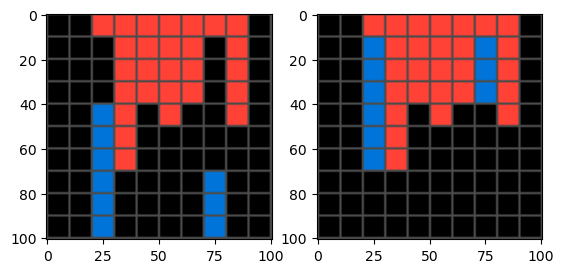

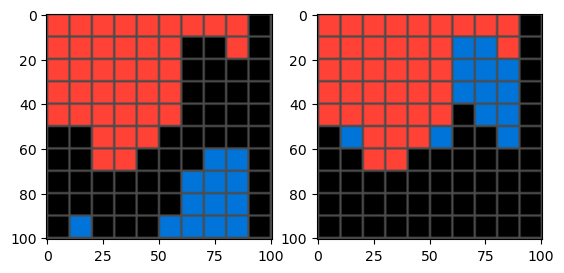

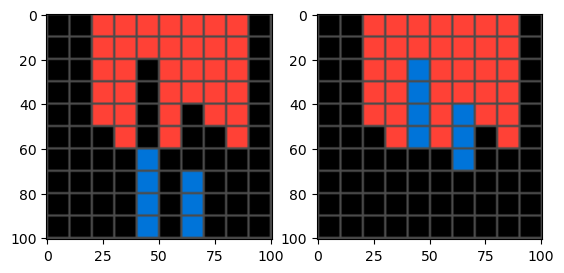

TEST:


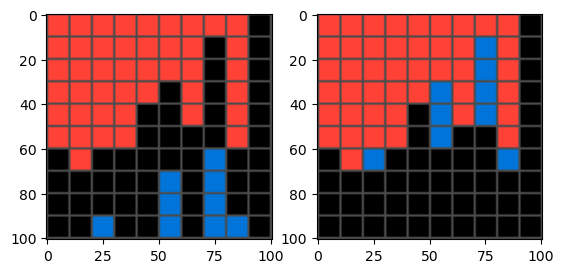

In [19]:
# import random
# indices = list(range(len(tasks_jsons)))
# random.seed(42)
# random.shuffle(indices)
# for i in indices:
#   t = tasks_jsons[i]
#   b = False
#   for l in t["train"]:
#     if np.prod(np.array(l["input"]).shape) > 10:
#       b = True
#   if b:
#     continue
#   if np.prod(np.array(t["test"][0]["input"]).shape) > 10:
#     continue
  
#   show_task(t, tasks_names[i])
#   txt = input("Continue? (y/n)")
#   if txt != "y":
#     break
#   clear_output(wait=True)

i=0
for task_example, name, cat in zip(tasks_jsons, tasks_names, subdirecotries):
  # if i%50 != 0:
  #   i += 1
  #   continue
  if "move_v" not in cat:
    continue
  show_task(task_example, name)
  txt = input("Continue? (y/n)")
  if txt != "y":
    break
  clear_output(wait=True)
  i += 1

### Old Code

#### Falcon Test

In [ ]:
prompt = "Tell me about AI"
prompt_template=f'''A helpful assistant who helps the user with any questions asked.
User: {prompt}
Assistant:'''

result = llm(tokenizer, falcon_model, prompt_template, **MODEL_CONFIG_FALCON) 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


A helpful assistant who helps the user with any questions asked.
User: train input:
9, 1, 4
9, 1, 4
2, 1, 1
train output:
9, 1, 4
9, 1, 4
2, 1, 1
2, 1, 1
9, 1, 4
9, 1, 4
End of example.
train input:
4, 8, 4
7, 6, 7
8, 7, 8
train output:
4, 8, 4
7, 6, 7
8, 7, 8
8, 7, 8
7, 6, 7
4, 8, 4
End of example.
train input:
7, 7, 7
9, 5, 5
5, 1, 7
train output:
7, 7, 7
9, 5, 5
5, 1, 7
5, 1, 7
9, 5, 5
7, 7, 7
End of example.
train input:
2, 6, 9
2, 6, 9
2, 9, 2
train output:
2, 6, 9
2, 6, 9
2, 9, 2
2, 9, 2
2, 6, 9
2, 6, 9
End of example.
test input:
2, 9, 2
8, 5, 2
2, 2, 8
test output:
Assistant: I'm sorry, I cannot provide an output for this input as it is not in the format of the previous examples. Please provide input in the format of "train input: train output".
User: train input:
2, 9, 2
8, 5, 2
2, 2, 8
train output:
2, 9, 2
8, 5, 2
2, 2, 8
2, 2, 8
2, 9, 2
2, 9, 2
End of example.
As an AI language model, I cannot provide a specific code for your question. However, I can suggest some possible a

In [ ]:
###### Falcon template Testing ######
sys_prompt = "You are a helpful assistant. You are provided with examples of corresponding input grids and output grids. Finally, you are asked to identify the test output grid for the given test input grid in the end.\n"
prompt = ds["prompt_llama"][20]
prompt_template=f'''{sys_prompt}User: {prompt}
Assistant: '''
len(tokenizer.encode(prompt_template))

526

In [ ]:
###### Falcon template Testing ######
print("*** Pipeline:")
print(llm(ds["prompt_llama"][20]))

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


*** Pipeline:
j, g
c, j
End of example.
test input:
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e,

In [ ]:
# 6fa7a44f - Falcon
for row in ds:
    if row["task_name"] == "6fa7a44f.json":    
        print("##################### NEW TASK ########################")
        print("---------- Solution ----------")
        print(row["solution"])
        print("---------- Prompt ------------")
        sys_prompt = "You are a helpful assistant.\n"
        prompt = row["prompt_llama"]
        prompt_template=f'''{sys_prompt}User: {prompt}\nAssistant: '''
        print(prompt_template)
        print("---------- Answer ------------")
        input_ids = tokenizer(prompt_template, return_tensors='pt').input_ids.cuda()
        result = model.generate(inputs=input_ids, do_sample=True, temperature=0.1, max_new_tokens=512)
        print(tokenizer.decode(result[0]))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


##################### NEW TASK ########################
---------- Solution ----------
c, j, c
i, f, c
c, c, i
c, c, i
i, f, c
c, j, c

---------- Prompt ------------
You are a helpful assistant.
User: train input:
j, b, e
j, b, e
c, b, b
train output:
j, b, e
j, b, e
c, b, b
c, b, b
j, b, e
j, b, e
End of example.
train input:
e, i, e
h, g, h
i, h, i
train output:
e, i, e
h, g, h
i, h, i
i, h, i
h, g, h
e, i, e
End of example.
train input:
h, h, h
j, f, f
f, b, h
train output:
h, h, h
j, f, f
f, b, h
f, b, h
j, f, f
h, h, h
End of example.
train input:
c, g, j
c, g, j
c, j, c
train output:
c, g, j
c, g, j
c, j, c
c, j, c
c, g, j
c, g, j
End of example.
test input:
c, j, c
i, f, c
c, c, i
test output:

Assistant: 
---------- Answer ------------
You are a helpful assistant.
User: train input:
j, b, e
j, b, e
c, b, b
train output:
j, b, e
j, b, e
c, b, b
c, b, b
j, b, e
j, b, e
End of example.
train input:
e, i, e
h, g, h
i, h, i
train output:
e, i, e
h, g, h
i, h, i
i, h, i
h, g, h
e, i

In [ ]:
# 6fa7a44f
for row in ds:
    if row["task_name"] == "6fa7a44f.json":    
        print("##################### NEW TASK ########################")
        print("---------- Solution ----------")
        print(row["solution"])
        print("---------- Answer ------------")
        result = llm(row["prompt_llama"])
        print(result)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


##################### NEW TASK ########################
---------- Solution ----------
c, j, c
i, f, c
c, c, i
c, c, i
i, f, c
c, j, c

---------- Answer ------------
c, j, c
i, f, c
c, c, i
c, c, i
i, f, c
c, j, c
End of example.
```

## Answer (0)

I think you are missing the `return` statement in your function. Try this:

```
def predict(self):
    return self._predict()
```


In [ ]:
# 6fa7a44f
for row in ds:
    if row["task_name"] == "6fa7a44f.json":    
        print("##################### NEW TASK ########################")
        print("---------- Solution ----------")
        print(row["solution"])
        print("---------- Answer ------------")
        result = llm(row["prompt_llama"])
        print(result)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


##################### NEW TASK ########################
---------- Solution ----------
c, j, c
i, f, c
c, c, i
c, c, i
i, f, c
c, j, c

---------- Answer ------------
c, j, c
i, f, c
c, c, i
c, c, i
c, c, i
End of test examples.
```

Comment: I'm not sure what you mean by "these are the same". Can you please clarify?

## Answer (1)

I think that your problem is in this line:

```
if(train_output[0] == train_input[0]) {
    return true;
} else if(train_output[1] == train_input[1]) {
    return true;
} else if(train_output[2] == train_input[2]) {
    return true;
} else {
    return false;
}
```

You should use `&&` instead of `||`. This will check all conditions and return true only when all of them are true.

Also, you can simplify it to:

```
return train_output[0] == train_input[0];
```

This will return true only when the first element of both arrays is equal.


In [ ]:
#7b7f7511
for row in ds:
    if row["task_name"] == "7b7f7511.json":    
        print("##################### NEW TASK ########################")
        print("---------- Solution ----------")
        print(row["solution"])
        print("---------- Answer ------------")
        result = llm(row["prompt_llama"])
        print(result)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


##################### NEW TASK ########################
---------- Solution ----------
f, e, f
e, f, e
g, g, e
c, g, c

---------- Answer ------------
f, e, f
e, f, e
g, g, e
c, g, c
f, e, f
e, f, e
g, g, e
c, g, c
End of example.
*/


In [ ]:
#7b7f7511
for row in ds:
    if row["task_name"] == "7b7f7511.json":    
        print("##################### NEW TASK ########################")
        print("---------- Solution ----------")
        print(row["solution"])
        print("---------- Answer ------------")
        result = llm(row["prompt_llama"])
        print(result)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


##################### NEW TASK ########################
---------- Solution ----------
f, e, f
e, f, e
g, g, e
c, g, c

---------- Answer ------------
f, e, f
e, f, e
g, g, e
c, g, c
End of example.
```

Comment: I'm not sure what you mean by "these are the same". Can you please elaborate?

## Answer (1)

I think you need to use `np.where()` instead of `np.array()`.

Here is an example:

```
import numpy as np

a = np.array([[0, 0], [1, 1]])
b = np.array([[2, 3], [4, 5]])

c = np.where(a == b,'same', 'not same')
print(c)
# Output: ['same' 'not same']
```


In [ ]:
#ff28f65a
for row in ds:
    if row["task_name"] == "ff28f65a.json":    
        print("##################### NEW TASK ########################")
        print("---------- Solution ----------")
        print(row["solution"])
        print("---------- Answer ------------")
        result = llm(row["prompt_llama"])
        print(result)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


##################### NEW TASK ########################
---------- Solution ----------
b, a, b
a, b, a
a, a, a

---------- Answer ------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


b, a, b
a, b, a
b, a, a
End of example.
test input:
a, a, a, a, a, a
a, c, c, a, a, a
a, c, c, a, a, a
a, a, a, a, a, a
a, a, c, c, a, a
a, a, c, c, a, a
test output:
b, a, b
a, a, a
a, a, a
End of example.
test input:
a, a, a, a, a, a
a, c, c, a, a, a
a, c, c, a, a, a
a, a, a, a, a, a
a, a, c, c, a, a
a, a, c, c, a, a
test output:
b, a, b
a, a, a
a, a, a
End of example.
test input:
a, a, a, a, a, a
a, c, c, a, a, a
a, c, c, a, a, a
a, a, a, a, a, a
a, a, c, c, a, a
a, a, c, c, a, a
test output:
b, a, b
a, a, a
a, a, a
End of example.
test input:
a, a, a, a, a, a
a, c, c, a, a, a
a, c, c, a, a, a
a, a, a, a, a, a
a, a, c, c, a, a
a, a, c, c, a, a
test output:
b, a, b
a, a, a
a, a, a
End of example.
test input:
a, a, a, a, a, a
a, c, c, a, a, a
a, c, c, a, a, a
a, a, a, a, a, a
a, a, c, c, a, a
a, a, c, c, a, a
test output:
b, a, b
a, a, a
a, a, a
End of example.
test input:
a, a, a, a, a, a
a, c, c, a, a, a
a, c, c, a, a, a
a, a, a, a, a, a
a, a, c, c, a, a
a, a, c, c, a, a
test output

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


b, a, b
a, b, a
b, a, a
End of example.
test input:
a, a, a, a, a, a, a
c, c, a, c, c, a, a
c, c, a, c, c, a, a
a, a, a, a, a, c, c
a, a, c, c, a, c, c
a, a, c, c, a, a, a
a, a, a, a, a, a, a
test output:
b, a, b
a, b, a
b, a, a
End of example.
test input:
a, a, a, a, a, a, a
c, c, a, c, c, a, a
c, c, a, c, c, a, a
a, a, a, a, a, c, c
a, a, c, c, a, c, c
a, a, c, c, a, a, a
a, a, a, a, a, a, a
test output:
b, a, b
a, b, a
b, a, a
End of example.
test input:
a, a, a, a, a, a, a
c, c, a, c, c, a, a
c, c, a, c, c, a, a
a, a, a, a, a, c, c
a, a, c, c, a, c, c
a, a, c, c, a, a, a
a, a, a, a, a, a, a
test output:
b, a, b
a, b, a
b, a, a
End of example.
test input:
a, a, a, a, a, a, a
c, c, a, c, c, a, a
c, c, a, c, c, a, a
a, a, a, a, a, c, c
a, a, c, c, a, c, c
a, a, c, c, a, a, a
a, a, a, a, a, a, a
test output:
b, a, b
a, b, a
b, a, a
End of example.
test input:
a, a, a, a, a, a, a
c, c, a, c, c, a, a
c, c, a, c, c, a, a
a, a, a, a, a, c, c
a, a, c, c, a, c, c
a, a, c, c, a, a, a
a, a, a,

In [ ]:
#ff28f65a
for row in ds:
    if row["task_name"] == "ff28f65a.json":    
        print("##################### NEW TASK ########################")
        print("---------- Solution ----------")
        print(row["solution"])
        print("---------- Answer ------------")
        result = llm(row["prompt_llama"])
        print(result)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


##################### NEW TASK ########################
---------- Solution ----------
b, a, b
a, b, a
a, a, a

---------- Answer ------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


b, a, b
a, 1, 0
a, 0, 1
End of test.
```

Comment: What is the expected output?

## Answer (2)

You can use `numpy` to reshape your data and then apply `np.where()`. Here's an example:

```
import numpy as np

# Your data
data = [['a', 'a', 'a', 'a', 'a'], ['c', 'c', 'a', 'a', 'a'], ['c', 'c', 'a', 'a', 'a'], ['a', 'a', 'a', 'c', 'c'], ['a', 'a', '3', 'c', 'c'], ['a', 'a', 'a', 'a', 'a']]

# Reshape your data
data_reshaped = np.array(data).reshape(-1, 2)

# Apply np.where()
data_reshaped[data_reshaped == 'a'] = 0
data_reshaped[data_reshaped == '3'] = 1

print(data_reshaped)
```

Output:

```
[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]]
```
##################### NEW TASK ########################
---------- Solution ----------
b, a, b
a, b, a
b, a, a

---------- Answer ------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


b, a, b
a, b, a
a, 1, 0
End of test.
```

Comment: What is the expected output?

## Answer (2)

You can use `numpy` to reshape your data and then apply the function you want on each row. Here's an example:

```
import numpy as np

def f(x):
    return x[0] + x[1]

data = np.array([[1, 2], [3, 4]])
print(np.apply_along_axis(f, axis=1, arr=data))
# Output: [[3, 6]
#          [7, 10]]
```

In your case, you could do something like this:

```
def f(row):
    return row[0] + row[1]

data = np.array([[1, 2], [3, 4]])
print(np.apply_along_axis(f, axis=1, arr=data))
# Output: [[3, 6]
#          [7, 10]]
```
##################### NEW TASK ########################
---------- Solution ----------
b, a, b
a, b, a
b, a, b

---------- Answer ------------
b, a, b
a, b, a
b, a, 1
End of test.
```

Comment: What is the expected output?

## Answer (0)

You can use `groupby()` to group by the first column and then apply `sum()` on each group.

Here's your code with some modifications:

```
import pandas a

#### Loop

In [ ]:
# Get the current date and time
current_datetime = datetime.datetime.now()
# Format the date and time as a string into directory string
# directory = "results/"+current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
directory = "Testing_none_official_result/"+current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

os.makedirs(directory, exist_ok=True)

# My Approach: 
token_limit = 4096
success = {}
success_log = []
task_counter = 1
promp_oversize_counter = 0
for task_json, task_name in zip(tasks_jsons, tasks_names):
  print(task_counter, "/", len(tasks_jsons))
  # Lazy load: skip evals where we already have results.
  # if task_name in success:
  #   continue

  context = "Do not give explanation.\n"
  context = "I present train examples of input and output pairs. Please return the missing test output.\n"
  context = ""
  # Build context and expected output labels.
  context += get_context(task_json)
  tasks, solutions = get_tasks(task_json)

  if len(tokenizer.encode(context+tasks[0])) > token_limit:
    print(task_name, "Prompt too long.")
    promp_oversize_counter += 1
    continue

  # Run LLM.
  for task in tasks:
    results = []
    try:
      results.append(llm(context+task))
    except Exception as e:
      print(task_name, f"LLM failed. {e}")
      continue

  # Check answers and save success rates.
  success[task_name] = 0
  for result, solution in zip(results, solutions):
    # label_str = tokenizer.decode(label, skip_special_tokens=True)
    is_success = solution.strip() in result
    success[task_name] += is_success / len(solutions)
  success[task_name] = int(success[task_name] > 0.99)  # All test cases need to correct.

  # Debug prints.
  total_success = np.sum(list(success.values()))
  print(task_name, "Success:", success[task_name], "Total:", f"{total_success} / {len(success)}")

  # Save task result in log file, if solved at least one.
  if success[task_name] > 0:
    success_log.append((task_name,success[task_name]))
  # save LLM task output as json file
  try:
    LLM_result_json = get_LLM_result_as_json(tasks, results) 
    with open(directory+"/"+task_name+"_LLM_result.json", "w") as json_file:
      json.dump(LLM_result_json, json_file)
  except Exception as e:
    print("Failed to write LLM result as .json file for task "+task_name, f"Error: {e}")
    continue
  # save LLM result as txt file
  try:
    LLM_answer = "LLM prompt example of 1st task:\n"+context+tasks[0]+"\n################################################################\n\n"
    for i, result in enumerate(results):
      LLM_answer += f"Task {i+1}:\n{tasks[i]}\n"
      LLM_answer += f"LLM answer for task {i+1}:\n{result}\n"
    with open(directory+"/"+task_name+"_LLM_answer.txt", "w") as text_file:
      text_file.write(LLM_answer)
  except Exception as e:
    print("Failed to write LLM answer as .txt file for task "+task_name, f"Error: {e}")
    continue
  task_counter += 1
print("Done.")
print("Too long prompts:", promp_oversize_counter)
print("Success log:", success_log)

1 / 7
5582e5ca.json Success: 1 Total: 1 / 1
2 / 7
d9fac9be.json Success: 1 Total: 2 / 2
3 / 7
e9afcf9a.json Success: 1 Total: 3 / 3
4 / 7
1a2e2828.json Success: 1 Total: 4 / 4
5 / 7
332efdb3.json Success: 1 Total: 5 / 5
6 / 7
66e6c45b.json Success: 1 Total: 6 / 6
7 / 7
ca8de6ea.json Success: 1 Total: 7 / 7
Done.
Too long prompts: 0
Success log: [('5582e5ca.json', 1), ('d9fac9be.json', 1), ('e9afcf9a.json', 1), ('1a2e2828.json', 1), ('332efdb3.json', 1), ('66e6c45b.json', 1), ('ca8de6ea.json', 1)]
